In [11]:
import torch 
import torchvision
import torch.nn as nn

import numpy as np
import math
import torchvision.transforms as transforms
from dataset_wrapper import get_pet_datasets
import matplotlib.pyplot as plt

In [12]:
class configConvNet(nn.Module):
    residual = False;
    def __init__(self, in_channels=3, base_channels=16, kernel_size=2, batch_normal=True, num_classes=4, num_layers=3, activation="RELU", residuals=False):
        super(configConvNet, self).__init__()
        input_channels = in_channels;
        layer = []
        self.residual = residuals;
        out_channels = 128;
        for i in range(num_layers):
            out_channels = base_channels * (2 ** i)
            layer.append(nn.Conv2d(input_channels, out_channels, kernel_size=5, stride=1, padding=2))
            if batch_normal:
                layer.append(nn.BatchNorm2d(out_channels))
            if activation.upper() == "RELU":
                layer.append(nn.ReLU())
            elif activation.upper() == "LEAKYRELU":
                layer.append(nn.LeakyReLU(0.1))
            elif activation.upper() == "GELU":
                layer.append(nn.GELU())
            layer.append(nn.MaxPool2d(kernel_size=2, stride=2))
            input_channels = out_channels
        if self.residual:
            self.downsample = None
            if in_channels != out_channels:
                print(f"in_channels:{in_channels}, out_channels:{out_channels}")
                self.downsample = nn.Sequential(
                    nn.Conv2d(
                        in_channels, 
                        out_channels, 
                        kernel_size=1, 
                        padding='same', 
                        bias=False
                    ),
                    nn.BatchNorm2d(out_channels) if batch_normal else nn.Identity(),
                    nn.MaxPool2d(kernel_size=2, stride=(2 ** num_layers)),
                )
            
        self.features = nn.Sequential(*layer)
        sqrt = 128 // (2 ** num_layers) #this isn't what a square root is.
        print(sqrt)
        self.fc = nn.Linear(out_channels*sqrt*sqrt, num_classes)

    def forward(self, x):
        identity = x
        out = self.features(x)
        
        if self.residual:
            identity = self.downsample(identity) if self.downsample else identity
            #print("identity shape:", identity.shape, "out shape", out.shape)
            out += identity 
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [13]:
# Plot training loss
def generate_charts(num_layers, activation, batch_norm, residuals, train_losses, val_accuracies):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label=f'Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training Loss Curve \n({num_layers} layers, {activation}, batchnorm={batch_norm}, residuals={residuals})')
    plt.legend()
    
    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label=f'Validation Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Validation Accuracy Curve \n({num_layers} layers, {activation}, batchnorm={batch_norm}, residuals={residuals})')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'layers{num_layers}_batch{batch_norm}_residuals{residuals}_{activation}.png')
    plt.show()

In [14]:
def append_text_to_file(file_path, text_to_append):
    try:
        with open(file_path, 'a') as file:
            file.write(text_to_append + '\n')
        print(f"Text appended to {file_path} successfully.")
    except Exception as e:
        print(f"Error: {e}")

In [15]:
import re
def extract_models_from_file(filepath):
    models_ive_trained = []

    # Read file
    with open(filepath, "r") as file:
        lines = file.readlines()

    # Define a regex pattern to capture required parameters
    pattern = re.compile(
        r"Batch normalisation: (\w+); residuals: (\w+); num_layers:(\d+); activation: (\w+)",
        re.IGNORECASE
    )

    # Process every line to match pattern
    for line in lines:
        match = pattern.search(line)
        if match:
            batch_norm, residuals, num_layers, activation = match.groups()
            model_string = f"{batch_norm}{residuals}{num_layers}{activation}"
            models_ive_trained.append(model_string)

    return models_ive_trained

In [16]:
def test_model(model, descript, batch_size, device):
    model.eval()

    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)
    # Disable gradient calculation for efficiency
    with torch.no_grad():
        correct = 0
        total = 0
        
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
    
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            
        new_acc_descript = '       Test Accuracy of the model on the 10000 test images: {:.2f} %'.format(100 * correct / total)
        append_text_to_file('AllAccuracies.txt', descript + "\n" + new_acc_descript)
        print(descript + "\n" + new_acc_descript)

In [17]:
#moved out here because it took too damn long at the start of every test

 #getting datasets
train_dataset, val_dataset, test_dataset = get_pet_datasets(img_width=128, img_height=128,root_path='./data' )



GPU name: NVIDIA GeForce RTX 3070 Laptop GPU
We've already trained this model, it's getting skipped.
We've already trained this model, it's getting skipped.
We've already trained this model, it's getting skipped.
We've already trained this model, it's getting skipped.
We've already trained this model, it's getting skipped.
We've already trained this model, it's getting skipped.
We've already trained this model, it's getting skipped.
We've already trained this model, it's getting skipped.
We've already trained this model, it's getting skipped.
We've already trained this model, it's getting skipped.
We've already trained this model, it's getting skipped.
We've already trained this model, it's getting skipped.
16
Batch normalisation: True; residuals: False; num_layers:3; activation: ReLU
Epoch [1/25], Step [50/58], Loss: 1.5984
Epoch [2/25], Step [50/58], Loss: 1.3855
Epoch [3/25], Step [50/58], Loss: 1.1959
Epoch [4/25], Step [50/58], Loss: 1.1462
Epoch [5/25], Step [50/58], Loss: 1.0149

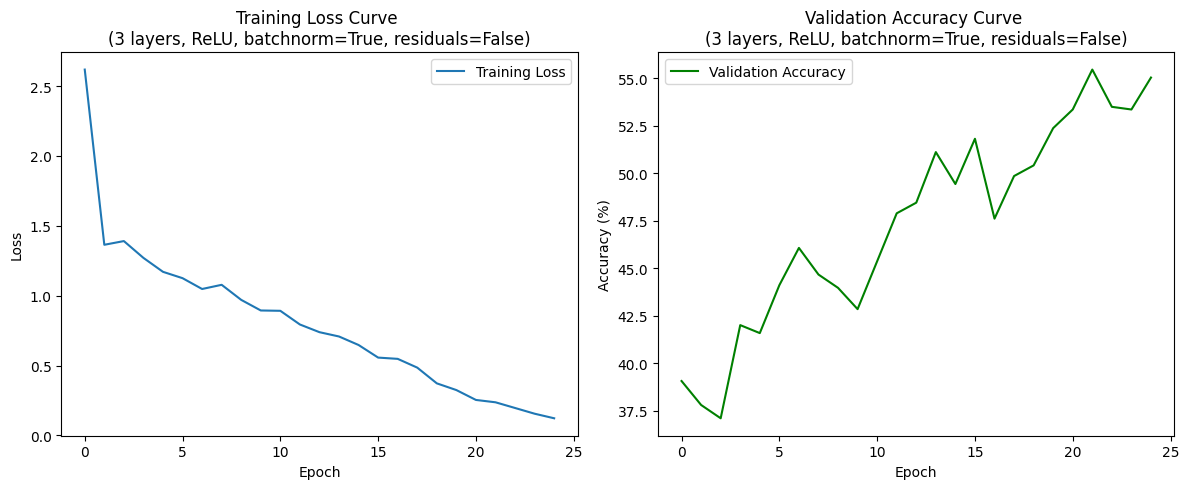

Text appended to AllAccuracies.txt successfully.
Batch normalisation: True; residuals: False; num_layers:3; activation: ReLU
       Test Accuracy of the model on the 10000 test images: 56.28 %
16
Batch normalisation: True; residuals: False; num_layers:3; activation: LeakyReLU
Epoch [1/25], Step [50/58], Loss: 1.3382
Epoch [2/25], Step [50/58], Loss: 1.5389
Epoch [3/25], Step [50/58], Loss: 1.5044
Epoch [4/25], Step [50/58], Loss: 0.9288
Epoch [5/25], Step [50/58], Loss: 1.0080
Epoch [6/25], Step [50/58], Loss: 1.0811
Epoch [7/25], Step [50/58], Loss: 1.2115
Epoch [8/25], Step [50/58], Loss: 0.9246
Epoch [9/25], Step [50/58], Loss: 1.0865
Epoch [10/25], Step [50/58], Loss: 0.7606
Epoch [11/25], Step [50/58], Loss: 0.7374
Epoch [12/25], Step [50/58], Loss: 0.6249
Epoch [13/25], Step [50/58], Loss: 0.6488
Epoch [14/25], Step [50/58], Loss: 0.6806
Epoch [15/25], Step [50/58], Loss: 0.6072
Epoch [16/25], Step [50/58], Loss: 0.5544
Epoch [17/25], Step [50/58], Loss: 0.4460
Epoch [18/25], Ste

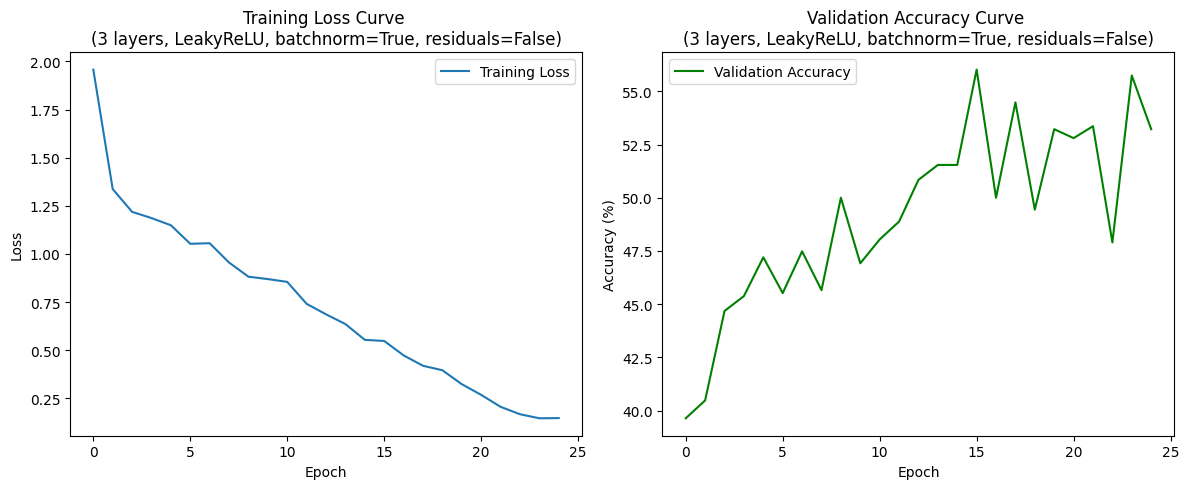

Text appended to AllAccuracies.txt successfully.
Batch normalisation: True; residuals: False; num_layers:3; activation: LeakyReLU
       Test Accuracy of the model on the 10000 test images: 58.52 %
16
Batch normalisation: True; residuals: False; num_layers:3; activation: GELU
Epoch [1/25], Step [50/58], Loss: 1.2652
Epoch [2/25], Step [50/58], Loss: 1.0878
Epoch [3/25], Step [50/58], Loss: 1.0747
Epoch [4/25], Step [50/58], Loss: 1.1261
Epoch [5/25], Step [50/58], Loss: 1.0737
Epoch [6/25], Step [50/58], Loss: 0.9422
Epoch [7/25], Step [50/58], Loss: 0.9177
Epoch [8/25], Step [50/58], Loss: 0.9899
Epoch [9/25], Step [50/58], Loss: 1.0839
Epoch [10/25], Step [50/58], Loss: 0.7705
Epoch [11/25], Step [50/58], Loss: 0.7008
Epoch [12/25], Step [50/58], Loss: 0.5243
Epoch [13/25], Step [50/58], Loss: 0.5825
Epoch [14/25], Step [50/58], Loss: 0.6054
Epoch [15/25], Step [50/58], Loss: 0.3927
Epoch [16/25], Step [50/58], Loss: 0.2859
Epoch [17/25], Step [50/58], Loss: 0.2871
Epoch [18/25], Ste

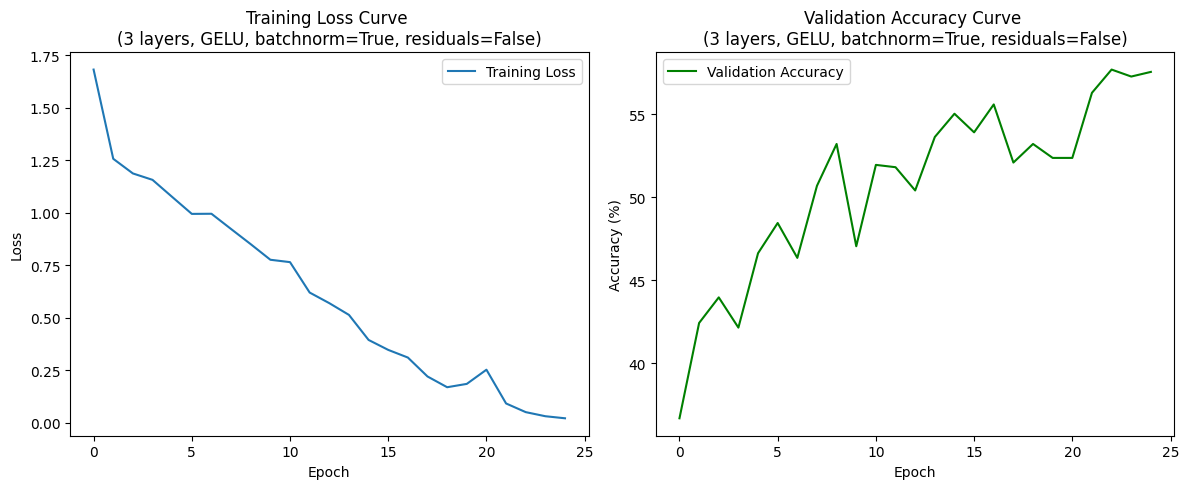

Text appended to AllAccuracies.txt successfully.
Batch normalisation: True; residuals: False; num_layers:3; activation: GELU
       Test Accuracy of the model on the 10000 test images: 55.87 %
8
Batch normalisation: True; residuals: False; num_layers:4; activation: ReLU
Epoch [1/25], Step [50/58], Loss: 1.1948
Epoch [2/25], Step [50/58], Loss: 1.1711
Epoch [3/25], Step [50/58], Loss: 1.0864
Epoch [4/25], Step [50/58], Loss: 1.1774
Epoch [5/25], Step [50/58], Loss: 1.1113
Epoch [6/25], Step [50/58], Loss: 1.0721
Epoch [7/25], Step [50/58], Loss: 1.1083
Epoch [8/25], Step [50/58], Loss: 0.9503
Epoch [9/25], Step [50/58], Loss: 0.7842
Epoch [10/25], Step [50/58], Loss: 0.7995
Epoch [11/25], Step [50/58], Loss: 0.6907
Epoch [12/25], Step [50/58], Loss: 0.5460
Epoch [13/25], Step [50/58], Loss: 0.5607
Epoch [14/25], Step [50/58], Loss: 0.4826
Epoch [15/25], Step [50/58], Loss: 0.2572
Epoch [16/25], Step [50/58], Loss: 0.1845
Epoch [17/25], Step [50/58], Loss: 0.2633
Epoch [18/25], Step [50/

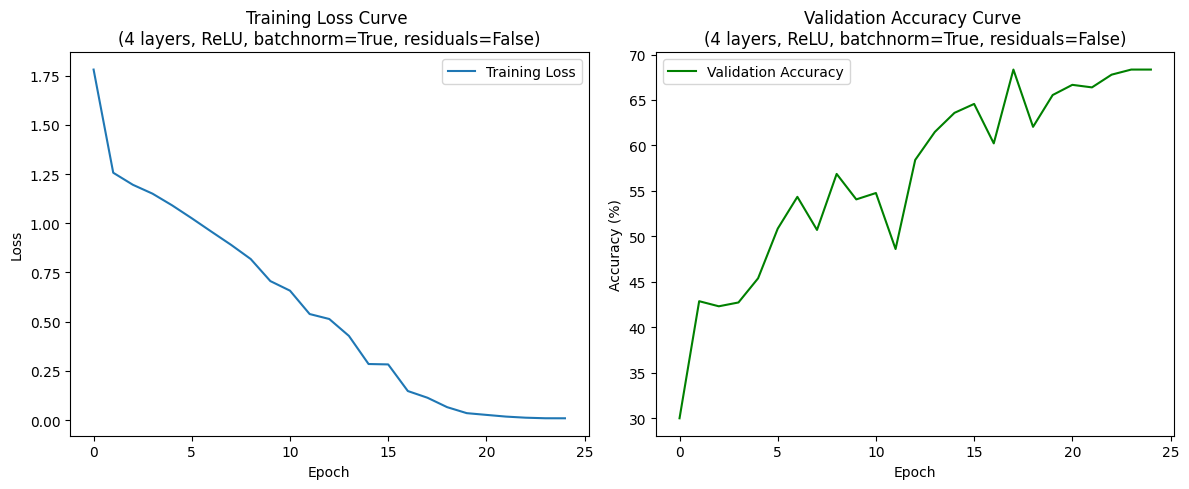

Text appended to AllAccuracies.txt successfully.
Batch normalisation: True; residuals: False; num_layers:4; activation: ReLU
       Test Accuracy of the model on the 10000 test images: 70.53 %
8
Batch normalisation: True; residuals: False; num_layers:4; activation: LeakyReLU
Epoch [1/25], Step [50/58], Loss: 1.1653
Epoch [2/25], Step [50/58], Loss: 1.2143
Epoch [3/25], Step [50/58], Loss: 1.1788
Epoch [4/25], Step [50/58], Loss: 1.1256
Epoch [5/25], Step [50/58], Loss: 0.9354
Epoch [6/25], Step [50/58], Loss: 0.9580
Epoch [7/25], Step [50/58], Loss: 0.9408
Epoch [8/25], Step [50/58], Loss: 0.7219
Epoch [9/25], Step [50/58], Loss: 0.7464
Epoch [10/25], Step [50/58], Loss: 0.6562
Epoch [11/25], Step [50/58], Loss: 0.6741
Epoch [12/25], Step [50/58], Loss: 0.5025
Epoch [13/25], Step [50/58], Loss: 0.3615
Epoch [14/25], Step [50/58], Loss: 0.3317
Epoch [15/25], Step [50/58], Loss: 0.2052
Epoch [16/25], Step [50/58], Loss: 0.2005
Epoch [17/25], Step [50/58], Loss: 0.1371
Epoch [18/25], Step

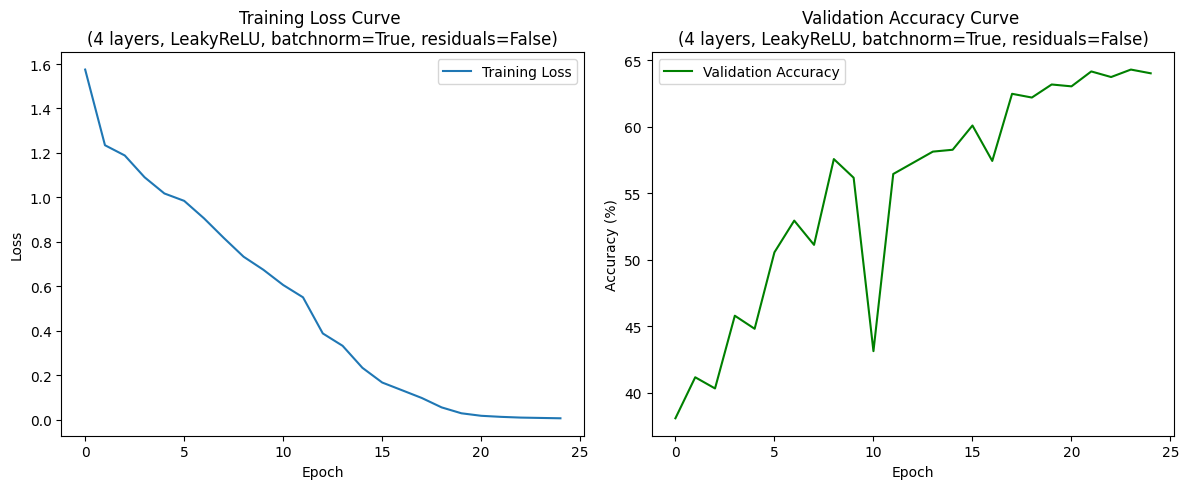

Text appended to AllAccuracies.txt successfully.
Batch normalisation: True; residuals: False; num_layers:4; activation: LeakyReLU
       Test Accuracy of the model on the 10000 test images: 69.27 %
8
Batch normalisation: True; residuals: False; num_layers:4; activation: GELU
Epoch [1/25], Step [50/58], Loss: 1.1943
Epoch [2/25], Step [50/58], Loss: 1.1300
Epoch [3/25], Step [50/58], Loss: 1.2244
Epoch [4/25], Step [50/58], Loss: 1.0260
Epoch [5/25], Step [50/58], Loss: 0.9050
Epoch [6/25], Step [50/58], Loss: 0.8911
Epoch [7/25], Step [50/58], Loss: 0.6943
Epoch [8/25], Step [50/58], Loss: 0.6282
Epoch [9/25], Step [50/58], Loss: 0.4537
Epoch [10/25], Step [50/58], Loss: 0.5448
Epoch [11/25], Step [50/58], Loss: 0.3525
Epoch [12/25], Step [50/58], Loss: 0.3661
Epoch [13/25], Step [50/58], Loss: 0.2043
Epoch [14/25], Step [50/58], Loss: 0.0973
Epoch [15/25], Step [50/58], Loss: 0.0483
Epoch [16/25], Step [50/58], Loss: 0.0409
Epoch [17/25], Step [50/58], Loss: 0.0168
Epoch [18/25], Step

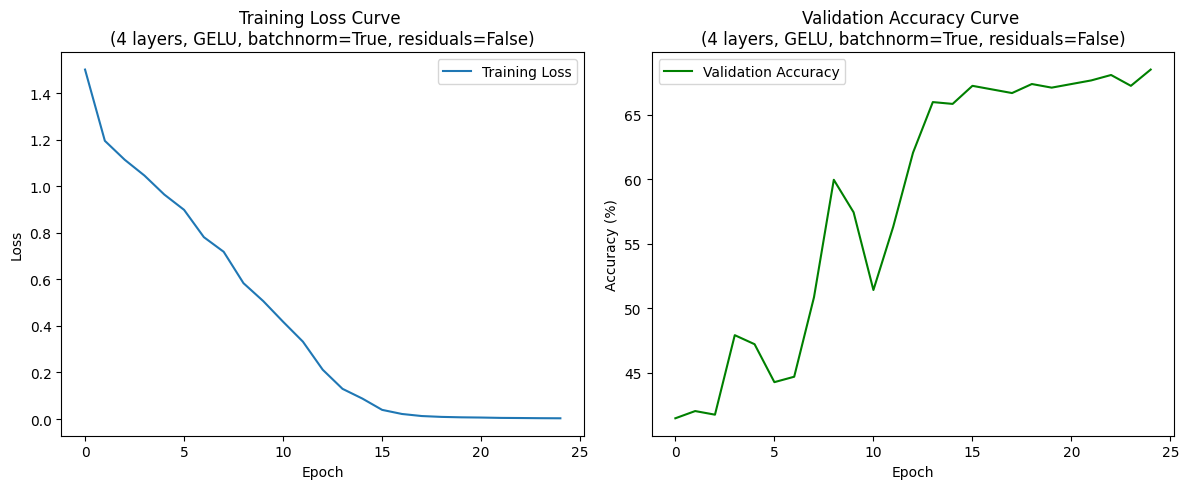

Text appended to AllAccuracies.txt successfully.
Batch normalisation: True; residuals: False; num_layers:4; activation: GELU
       Test Accuracy of the model on the 10000 test images: 73.46 %
4
Batch normalisation: True; residuals: False; num_layers:5; activation: ReLU
Epoch [1/25], Step [50/58], Loss: 1.3557
Epoch [2/25], Step [50/58], Loss: 1.1717
Epoch [3/25], Step [50/58], Loss: 1.2730
Epoch [4/25], Step [50/58], Loss: 1.0514
Epoch [5/25], Step [50/58], Loss: 1.2133
Epoch [6/25], Step [50/58], Loss: 0.9837
Epoch [7/25], Step [50/58], Loss: 0.8636
Epoch [8/25], Step [50/58], Loss: 0.8194
Epoch [9/25], Step [50/58], Loss: 0.7199
Epoch [10/25], Step [50/58], Loss: 0.6206
Epoch [11/25], Step [50/58], Loss: 0.6144
Epoch [12/25], Step [50/58], Loss: 0.3424
Epoch [13/25], Step [50/58], Loss: 0.1839
Epoch [14/25], Step [50/58], Loss: 0.2842
Epoch [15/25], Step [50/58], Loss: 0.0775
Epoch [16/25], Step [50/58], Loss: 0.0770
Epoch [17/25], Step [50/58], Loss: 0.0372
Epoch [18/25], Step [50/

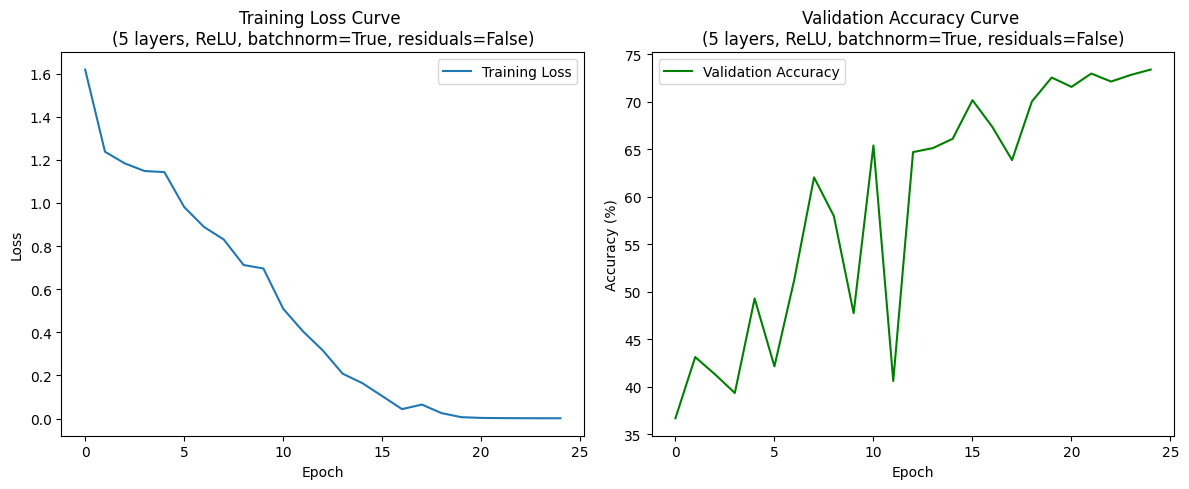

Text appended to AllAccuracies.txt successfully.
Batch normalisation: True; residuals: False; num_layers:5; activation: ReLU
       Test Accuracy of the model on the 10000 test images: 74.44 %
4
Batch normalisation: True; residuals: False; num_layers:5; activation: LeakyReLU
Epoch [1/25], Step [50/58], Loss: 1.3554
Epoch [2/25], Step [50/58], Loss: 1.0822
Epoch [3/25], Step [50/58], Loss: 1.1335
Epoch [4/25], Step [50/58], Loss: 1.0599
Epoch [5/25], Step [50/58], Loss: 0.8625
Epoch [6/25], Step [50/58], Loss: 0.8173
Epoch [7/25], Step [50/58], Loss: 0.8057
Epoch [8/25], Step [50/58], Loss: 0.7216
Epoch [9/25], Step [50/58], Loss: 0.4249
Epoch [10/25], Step [50/58], Loss: 0.4497
Epoch [11/25], Step [50/58], Loss: 0.3283
Epoch [12/25], Step [50/58], Loss: 0.1292
Epoch [13/25], Step [50/58], Loss: 0.0814
Epoch [14/25], Step [50/58], Loss: 0.0501
Epoch [15/25], Step [50/58], Loss: 0.0205
Epoch [16/25], Step [50/58], Loss: 0.0061
Epoch [17/25], Step [50/58], Loss: 0.0027
Epoch [18/25], Step

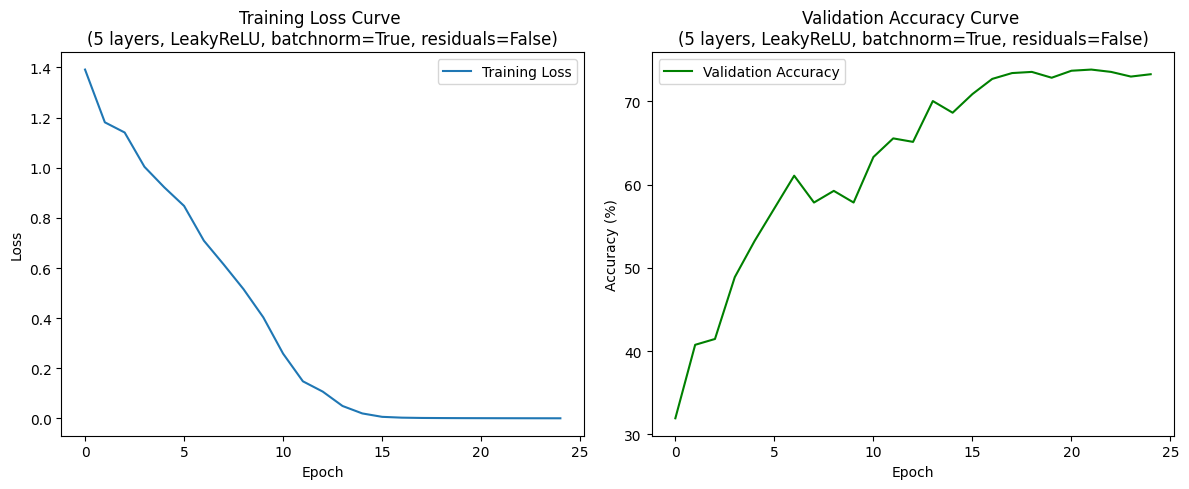

Text appended to AllAccuracies.txt successfully.
Batch normalisation: True; residuals: False; num_layers:5; activation: LeakyReLU
       Test Accuracy of the model on the 10000 test images: 72.91 %
4
Batch normalisation: True; residuals: False; num_layers:5; activation: GELU
Epoch [1/25], Step [50/58], Loss: 1.2392
Epoch [2/25], Step [50/58], Loss: 1.2312
Epoch [3/25], Step [50/58], Loss: 1.0546
Epoch [4/25], Step [50/58], Loss: 0.9823
Epoch [5/25], Step [50/58], Loss: 0.8735
Epoch [6/25], Step [50/58], Loss: 0.8594
Epoch [7/25], Step [50/58], Loss: 0.6816
Epoch [8/25], Step [50/58], Loss: 0.5635
Epoch [9/25], Step [50/58], Loss: 0.5838
Epoch [10/25], Step [50/58], Loss: 0.4321
Epoch [11/25], Step [50/58], Loss: 0.2140
Epoch [12/25], Step [50/58], Loss: 0.1890
Epoch [13/25], Step [50/58], Loss: 0.0845
Epoch [14/25], Step [50/58], Loss: 0.0451
Epoch [15/25], Step [50/58], Loss: 0.0284
Epoch [16/25], Step [50/58], Loss: 0.0090
Epoch [17/25], Step [50/58], Loss: 0.0028
Epoch [18/25], Step

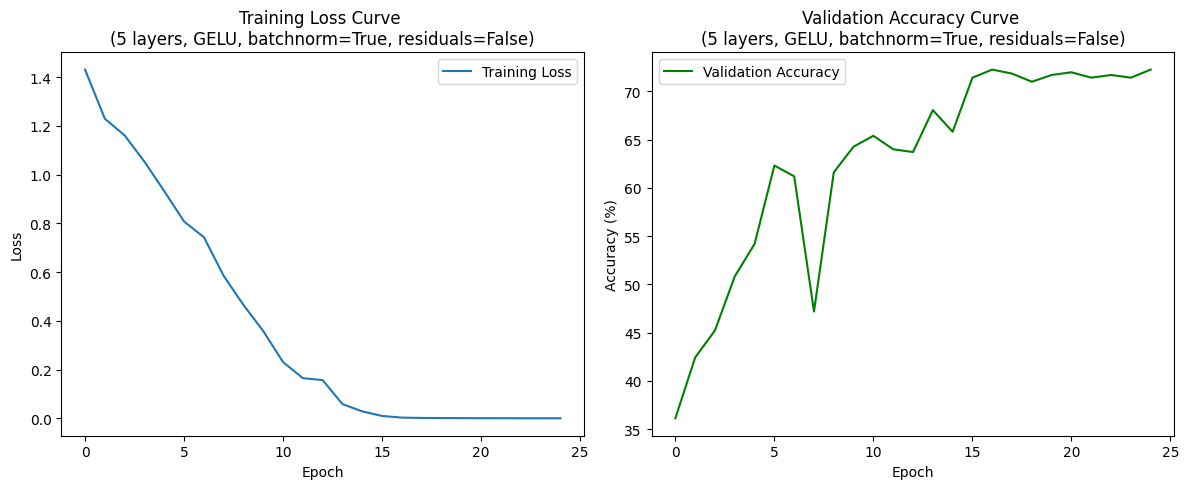

Text appended to AllAccuracies.txt successfully.
Batch normalisation: True; residuals: False; num_layers:5; activation: GELU
       Test Accuracy of the model on the 10000 test images: 74.58 %
2
Batch normalisation: True; residuals: False; num_layers:6; activation: ReLU
Epoch [1/25], Step [50/58], Loss: 1.4343
Epoch [2/25], Step [50/58], Loss: 1.2048
Epoch [3/25], Step [50/58], Loss: 1.2776
Epoch [4/25], Step [50/58], Loss: 1.1580
Epoch [5/25], Step [50/58], Loss: 1.0901
Epoch [6/25], Step [50/58], Loss: 1.1025
Epoch [7/25], Step [50/58], Loss: 1.1151
Epoch [8/25], Step [50/58], Loss: 0.7047
Epoch [9/25], Step [50/58], Loss: 0.8283
Epoch [10/25], Step [50/58], Loss: 0.8031
Epoch [11/25], Step [50/58], Loss: 0.6489
Epoch [12/25], Step [50/58], Loss: 0.7004
Epoch [13/25], Step [50/58], Loss: 0.3437
Epoch [14/25], Step [50/58], Loss: 0.6746
Epoch [15/25], Step [50/58], Loss: 0.2514
Epoch [16/25], Step [50/58], Loss: 0.2145
Epoch [17/25], Step [50/58], Loss: 0.2902
Epoch [18/25], Step [50/

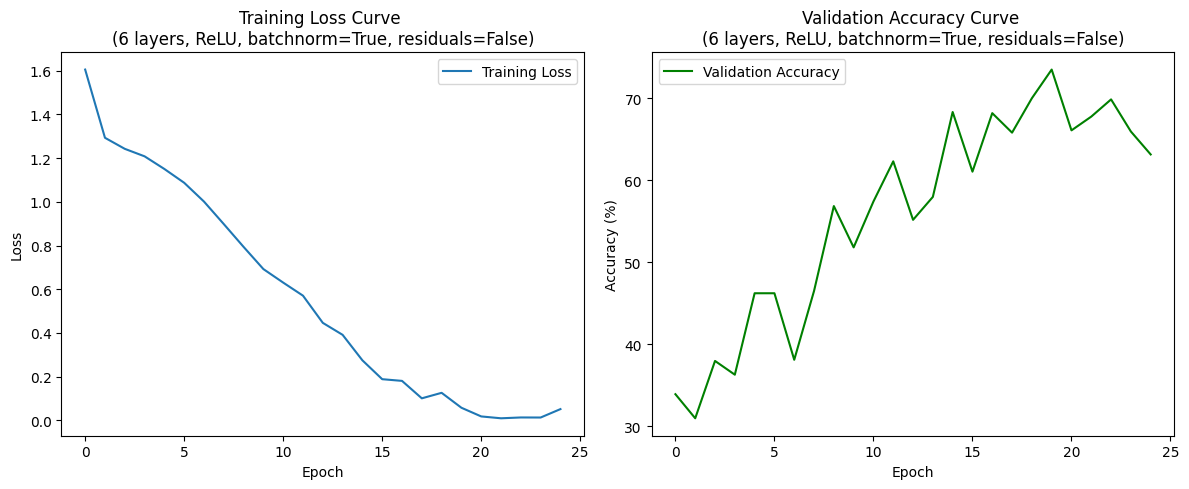

Text appended to AllAccuracies.txt successfully.
Batch normalisation: True; residuals: False; num_layers:6; activation: ReLU
       Test Accuracy of the model on the 10000 test images: 63.97 %
2
Batch normalisation: True; residuals: False; num_layers:6; activation: LeakyReLU
Epoch [1/25], Step [50/58], Loss: 1.2835
Epoch [2/25], Step [50/58], Loss: 1.2482
Epoch [3/25], Step [50/58], Loss: 1.2196
Epoch [4/25], Step [50/58], Loss: 1.1541
Epoch [5/25], Step [50/58], Loss: 1.0415
Epoch [6/25], Step [50/58], Loss: 1.0656
Epoch [7/25], Step [50/58], Loss: 0.8884
Epoch [8/25], Step [50/58], Loss: 0.8251
Epoch [9/25], Step [50/58], Loss: 0.7431
Epoch [10/25], Step [50/58], Loss: 0.6938
Epoch [11/25], Step [50/58], Loss: 0.5782
Epoch [12/25], Step [50/58], Loss: 0.5327
Epoch [13/25], Step [50/58], Loss: 0.4099
Epoch [14/25], Step [50/58], Loss: 0.3047
Epoch [15/25], Step [50/58], Loss: 0.1576
Epoch [16/25], Step [50/58], Loss: 0.1053
Epoch [17/25], Step [50/58], Loss: 0.1174
Epoch [18/25], Step

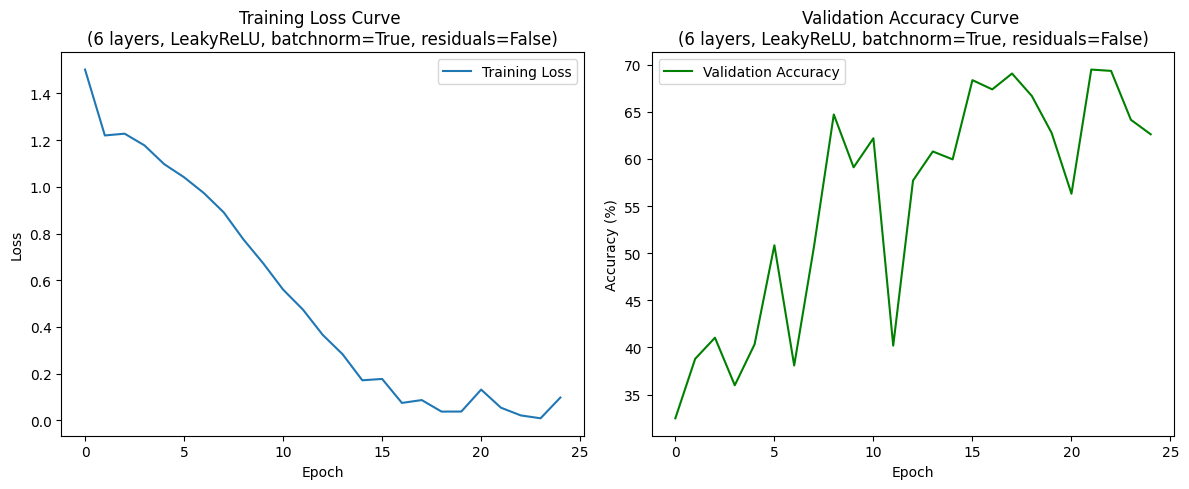

Text appended to AllAccuracies.txt successfully.
Batch normalisation: True; residuals: False; num_layers:6; activation: LeakyReLU
       Test Accuracy of the model on the 10000 test images: 63.69 %
2
Batch normalisation: True; residuals: False; num_layers:6; activation: GELU
Epoch [1/25], Step [50/58], Loss: 1.2862
Epoch [2/25], Step [50/58], Loss: 1.2565
Epoch [3/25], Step [50/58], Loss: 1.1558
Epoch [4/25], Step [50/58], Loss: 1.0995
Epoch [5/25], Step [50/58], Loss: 1.0312
Epoch [6/25], Step [50/58], Loss: 0.9788
Epoch [7/25], Step [50/58], Loss: 0.9073
Epoch [8/25], Step [50/58], Loss: 0.9030
Epoch [9/25], Step [50/58], Loss: 0.6835
Epoch [10/25], Step [50/58], Loss: 0.3990
Epoch [11/25], Step [50/58], Loss: 0.5639
Epoch [12/25], Step [50/58], Loss: 0.3714
Epoch [13/25], Step [50/58], Loss: 0.3120
Epoch [14/25], Step [50/58], Loss: 0.2701
Epoch [15/25], Step [50/58], Loss: 0.1970
Epoch [16/25], Step [50/58], Loss: 0.0855
Epoch [17/25], Step [50/58], Loss: 0.0592
Epoch [18/25], Step

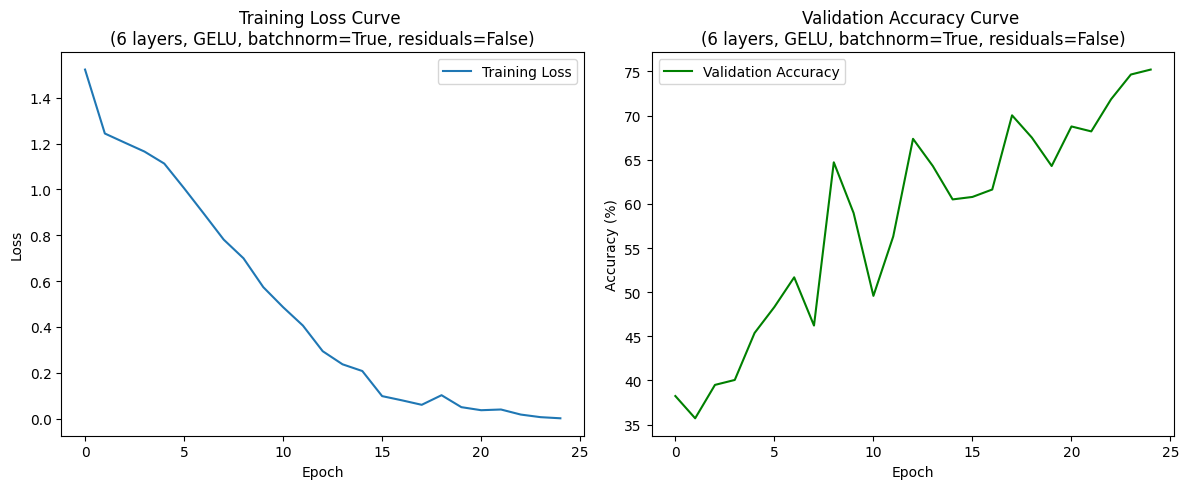

Text appended to AllAccuracies.txt successfully.
Batch normalisation: True; residuals: False; num_layers:6; activation: GELU
       Test Accuracy of the model on the 10000 test images: 76.54 %
in_channels:3, out_channels:64
16
Batch normalisation: False; residuals: True; num_layers:3; activation: ReLU
Epoch [1/25], Step [50/58], Loss: 1.3940
Epoch [2/25], Step [50/58], Loss: 1.1993
Epoch [3/25], Step [50/58], Loss: 1.1247
Epoch [4/25], Step [50/58], Loss: 1.1813
Epoch [5/25], Step [50/58], Loss: 1.1252
Epoch [6/25], Step [50/58], Loss: 1.1713
Epoch [7/25], Step [50/58], Loss: 1.0168
Epoch [8/25], Step [50/58], Loss: 1.0176
Epoch [9/25], Step [50/58], Loss: 1.0279
Epoch [10/25], Step [50/58], Loss: 0.9995
Epoch [11/25], Step [50/58], Loss: 1.0232
Epoch [12/25], Step [50/58], Loss: 0.9465
Epoch [13/25], Step [50/58], Loss: 0.8584
Epoch [14/25], Step [50/58], Loss: 0.8974
Epoch [15/25], Step [50/58], Loss: 0.7875
Epoch [16/25], Step [50/58], Loss: 0.8559
Epoch [17/25], Step [50/58], Loss:

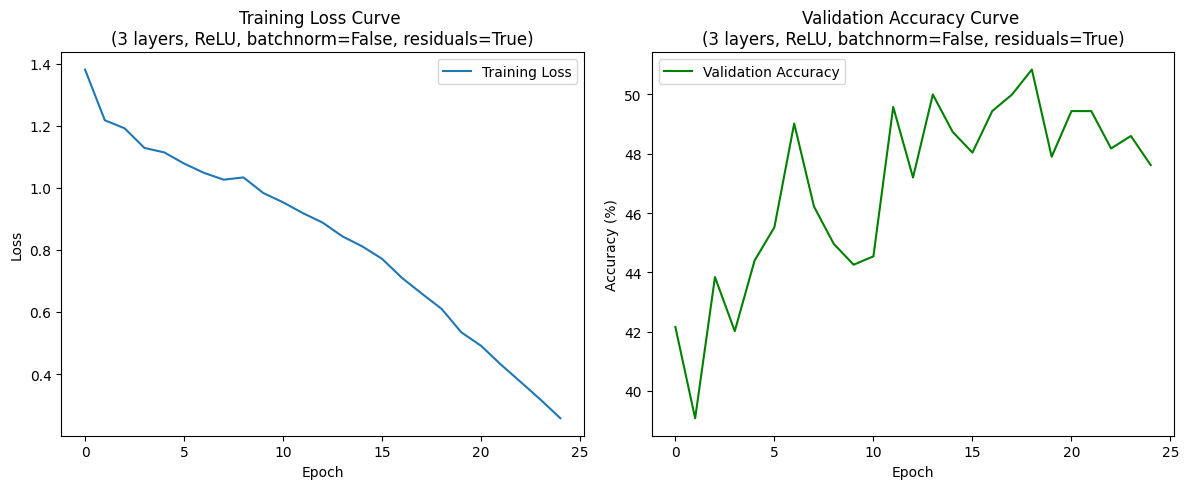

Text appended to AllAccuracies.txt successfully.
Batch normalisation: False; residuals: True; num_layers:3; activation: ReLU
       Test Accuracy of the model on the 10000 test images: 49.72 %
in_channels:3, out_channels:64
16
Batch normalisation: False; residuals: True; num_layers:3; activation: LeakyReLU
Epoch [1/25], Step [50/58], Loss: 1.3235
Epoch [2/25], Step [50/58], Loss: 1.2569
Epoch [3/25], Step [50/58], Loss: 1.2050
Epoch [4/25], Step [50/58], Loss: 1.0918
Epoch [5/25], Step [50/58], Loss: 1.2512
Epoch [6/25], Step [50/58], Loss: 0.9452
Epoch [7/25], Step [50/58], Loss: 1.1167
Epoch [8/25], Step [50/58], Loss: 0.9082
Epoch [9/25], Step [50/58], Loss: 1.0338
Epoch [10/25], Step [50/58], Loss: 0.7985
Epoch [11/25], Step [50/58], Loss: 0.7910
Epoch [12/25], Step [50/58], Loss: 0.6589
Epoch [13/25], Step [50/58], Loss: 0.6926
Epoch [14/25], Step [50/58], Loss: 0.5691
Epoch [15/25], Step [50/58], Loss: 0.6882
Epoch [16/25], Step [50/58], Loss: 0.4251
Epoch [17/25], Step [50/58], 

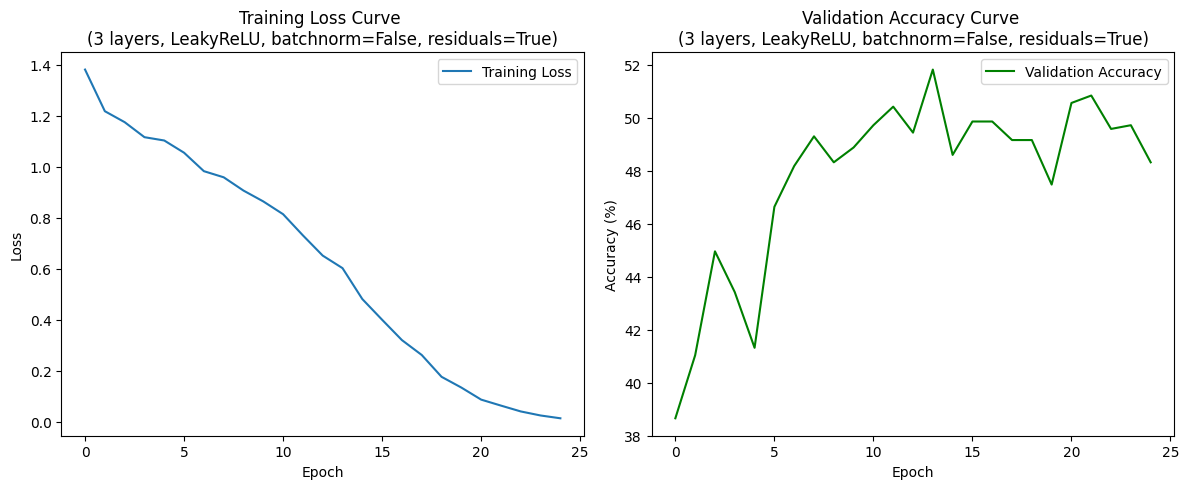

Text appended to AllAccuracies.txt successfully.
Batch normalisation: False; residuals: True; num_layers:3; activation: LeakyReLU
       Test Accuracy of the model on the 10000 test images: 53.35 %
in_channels:3, out_channels:64
16
Batch normalisation: False; residuals: True; num_layers:3; activation: GELU
Epoch [1/25], Step [50/58], Loss: 1.2885
Epoch [2/25], Step [50/58], Loss: 1.1959
Epoch [3/25], Step [50/58], Loss: 1.2326
Epoch [4/25], Step [50/58], Loss: 1.1800
Epoch [5/25], Step [50/58], Loss: 1.0059
Epoch [6/25], Step [50/58], Loss: 1.0279
Epoch [7/25], Step [50/58], Loss: 1.1171
Epoch [8/25], Step [50/58], Loss: 0.9233
Epoch [9/25], Step [50/58], Loss: 0.9052
Epoch [10/25], Step [50/58], Loss: 0.8710
Epoch [11/25], Step [50/58], Loss: 0.7614
Epoch [12/25], Step [50/58], Loss: 0.5803
Epoch [13/25], Step [50/58], Loss: 0.5303
Epoch [14/25], Step [50/58], Loss: 0.3415
Epoch [15/25], Step [50/58], Loss: 0.3069
Epoch [16/25], Step [50/58], Loss: 0.1326
Epoch [17/25], Step [50/58], 

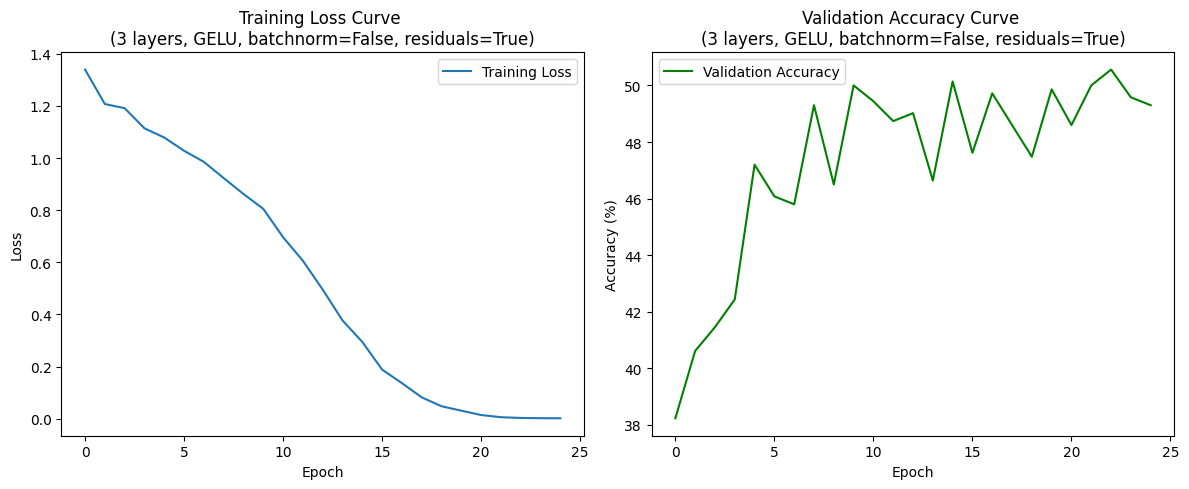

Text appended to AllAccuracies.txt successfully.
Batch normalisation: False; residuals: True; num_layers:3; activation: GELU
       Test Accuracy of the model on the 10000 test images: 52.65 %
in_channels:3, out_channels:128
8
Batch normalisation: False; residuals: True; num_layers:4; activation: ReLU
Epoch [1/25], Step [50/58], Loss: 1.3282
Epoch [2/25], Step [50/58], Loss: 1.1768
Epoch [3/25], Step [50/58], Loss: 1.2755
Epoch [4/25], Step [50/58], Loss: 1.1787
Epoch [5/25], Step [50/58], Loss: 1.0201
Epoch [6/25], Step [50/58], Loss: 1.0371
Epoch [7/25], Step [50/58], Loss: 1.0403
Epoch [8/25], Step [50/58], Loss: 1.0700
Epoch [9/25], Step [50/58], Loss: 1.0987
Epoch [10/25], Step [50/58], Loss: 0.9848
Epoch [11/25], Step [50/58], Loss: 0.9492
Epoch [12/25], Step [50/58], Loss: 0.8675
Epoch [13/25], Step [50/58], Loss: 0.9264
Epoch [14/25], Step [50/58], Loss: 0.7733
Epoch [15/25], Step [50/58], Loss: 0.7437
Epoch [16/25], Step [50/58], Loss: 0.5552
Epoch [17/25], Step [50/58], Loss:

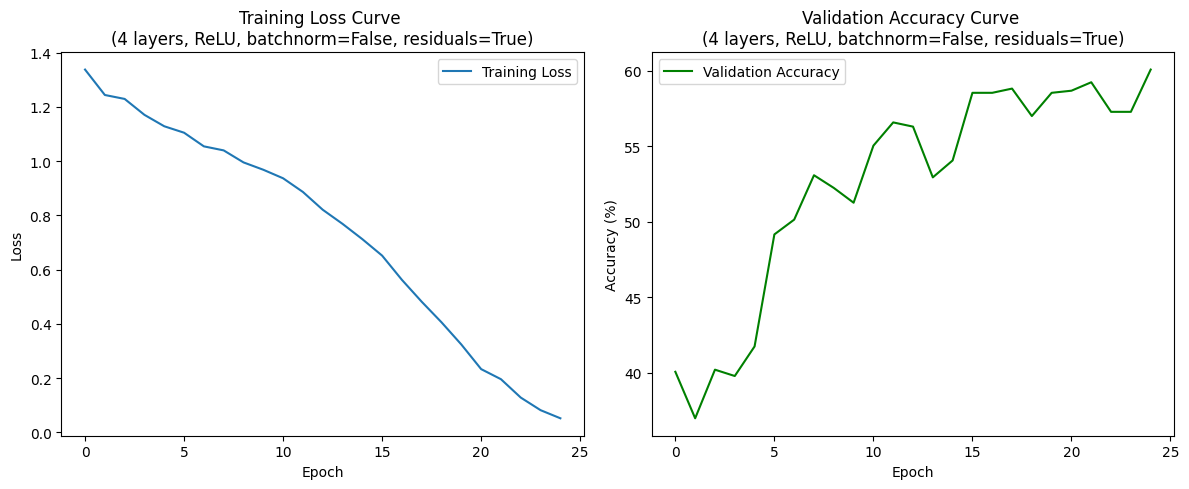

Text appended to AllAccuracies.txt successfully.
Batch normalisation: False; residuals: True; num_layers:4; activation: ReLU
       Test Accuracy of the model on the 10000 test images: 56.98 %
in_channels:3, out_channels:128
8
Batch normalisation: False; residuals: True; num_layers:4; activation: LeakyReLU
Epoch [1/25], Step [50/58], Loss: 1.2161
Epoch [2/25], Step [50/58], Loss: 1.1739
Epoch [3/25], Step [50/58], Loss: 1.1795
Epoch [4/25], Step [50/58], Loss: 1.1579
Epoch [5/25], Step [50/58], Loss: 1.1554
Epoch [6/25], Step [50/58], Loss: 1.0079
Epoch [7/25], Step [50/58], Loss: 0.9058
Epoch [8/25], Step [50/58], Loss: 1.1070
Epoch [9/25], Step [50/58], Loss: 0.9865
Epoch [10/25], Step [50/58], Loss: 0.7980
Epoch [11/25], Step [50/58], Loss: 0.9166
Epoch [12/25], Step [50/58], Loss: 0.5823
Epoch [13/25], Step [50/58], Loss: 0.4219
Epoch [14/25], Step [50/58], Loss: 0.2984
Epoch [15/25], Step [50/58], Loss: 0.2547
Epoch [16/25], Step [50/58], Loss: 0.0922
Epoch [17/25], Step [50/58], 

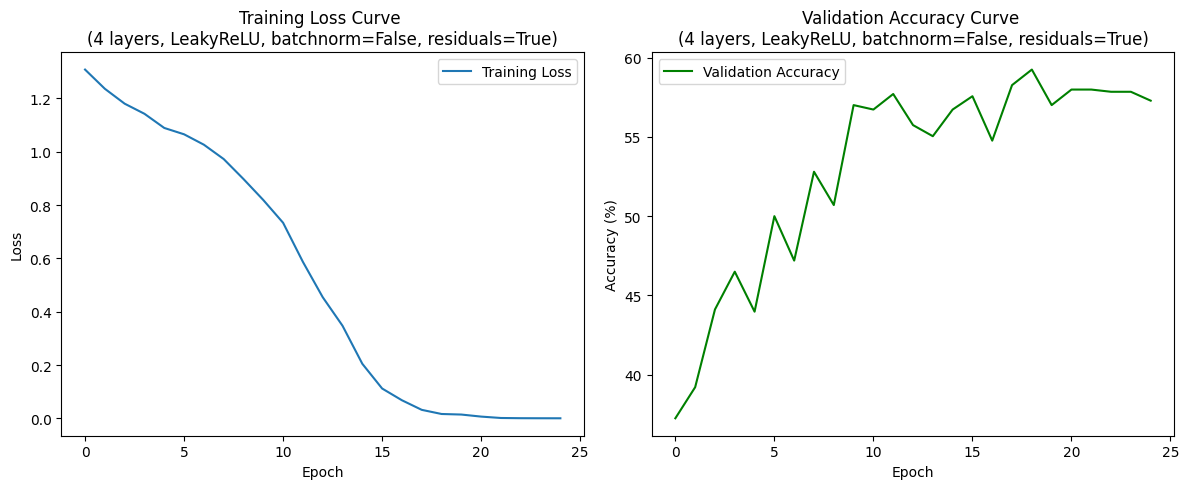

Text appended to AllAccuracies.txt successfully.
Batch normalisation: False; residuals: True; num_layers:4; activation: LeakyReLU
       Test Accuracy of the model on the 10000 test images: 60.06 %
in_channels:3, out_channels:128
8
Batch normalisation: False; residuals: True; num_layers:4; activation: GELU
Epoch [1/25], Step [50/58], Loss: 1.3120
Epoch [2/25], Step [50/58], Loss: 1.1946
Epoch [3/25], Step [50/58], Loss: 1.0603
Epoch [4/25], Step [50/58], Loss: 1.1541
Epoch [5/25], Step [50/58], Loss: 1.1883
Epoch [6/25], Step [50/58], Loss: 1.0269
Epoch [7/25], Step [50/58], Loss: 0.9727
Epoch [8/25], Step [50/58], Loss: 0.8363
Epoch [9/25], Step [50/58], Loss: 0.8700
Epoch [10/25], Step [50/58], Loss: 0.7187
Epoch [11/25], Step [50/58], Loss: 0.5060
Epoch [12/25], Step [50/58], Loss: 0.3406
Epoch [13/25], Step [50/58], Loss: 0.2347
Epoch [14/25], Step [50/58], Loss: 0.1170
Epoch [15/25], Step [50/58], Loss: 0.0552
Epoch [16/25], Step [50/58], Loss: 0.0302
Epoch [17/25], Step [50/58], 

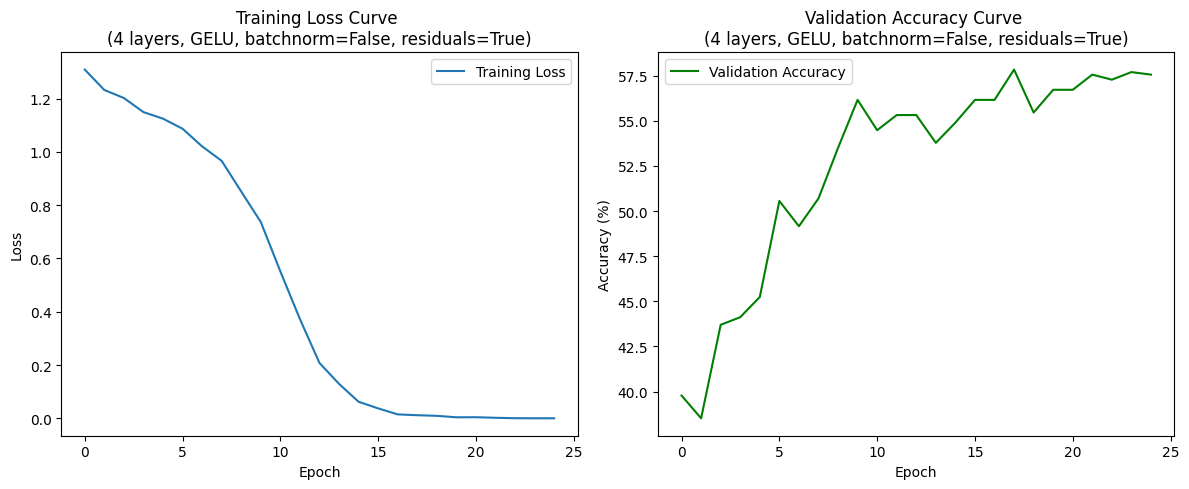

Text appended to AllAccuracies.txt successfully.
Batch normalisation: False; residuals: True; num_layers:4; activation: GELU
       Test Accuracy of the model on the 10000 test images: 56.28 %
in_channels:3, out_channels:256
4
Batch normalisation: False; residuals: True; num_layers:5; activation: ReLU
Epoch [1/25], Step [50/58], Loss: 1.3007
Epoch [2/25], Step [50/58], Loss: 1.1795
Epoch [3/25], Step [50/58], Loss: 1.1778
Epoch [4/25], Step [50/58], Loss: 1.0729
Epoch [5/25], Step [50/58], Loss: 1.0222
Epoch [6/25], Step [50/58], Loss: 1.0785
Epoch [7/25], Step [50/58], Loss: 0.9918
Epoch [8/25], Step [50/58], Loss: 1.0362
Epoch [9/25], Step [50/58], Loss: 0.9521
Epoch [10/25], Step [50/58], Loss: 1.0266
Epoch [11/25], Step [50/58], Loss: 0.6749
Epoch [12/25], Step [50/58], Loss: 0.6845
Epoch [13/25], Step [50/58], Loss: 0.5612
Epoch [14/25], Step [50/58], Loss: 0.5365
Epoch [15/25], Step [50/58], Loss: 0.6165
Epoch [16/25], Step [50/58], Loss: 0.3474
Epoch [17/25], Step [50/58], Loss:

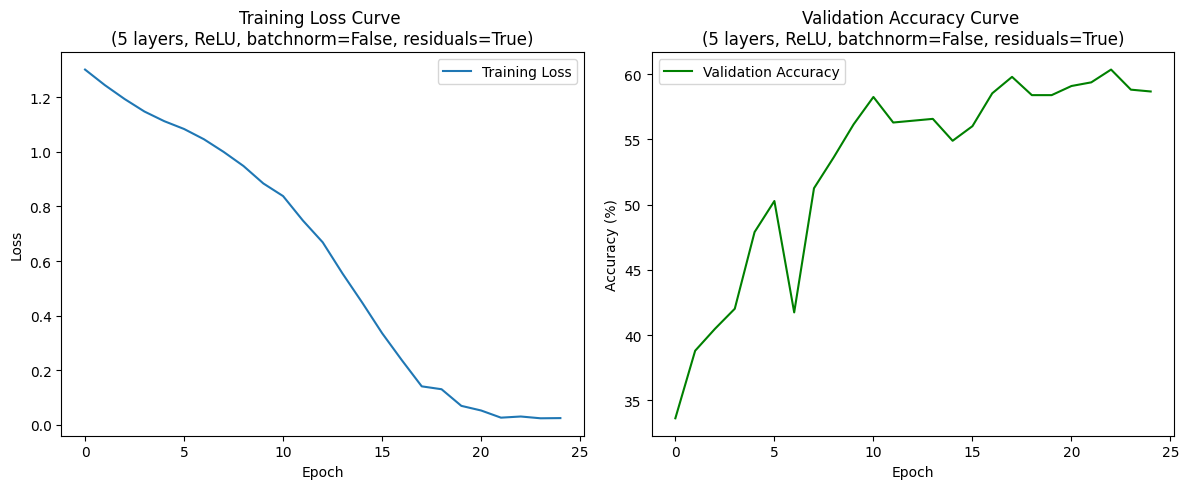

Text appended to AllAccuracies.txt successfully.
Batch normalisation: False; residuals: True; num_layers:5; activation: ReLU
       Test Accuracy of the model on the 10000 test images: 63.13 %
in_channels:3, out_channels:256
4
Batch normalisation: False; residuals: True; num_layers:5; activation: LeakyReLU
Epoch [1/25], Step [50/58], Loss: 1.2768
Epoch [2/25], Step [50/58], Loss: 1.0996
Epoch [3/25], Step [50/58], Loss: 1.1689
Epoch [4/25], Step [50/58], Loss: 1.1085
Epoch [5/25], Step [50/58], Loss: 1.0483
Epoch [6/25], Step [50/58], Loss: 1.0535
Epoch [7/25], Step [50/58], Loss: 1.0343
Epoch [8/25], Step [50/58], Loss: 0.9856
Epoch [9/25], Step [50/58], Loss: 0.7368
Epoch [10/25], Step [50/58], Loss: 0.5304
Epoch [11/25], Step [50/58], Loss: 0.6443
Epoch [12/25], Step [50/58], Loss: 0.3070
Epoch [13/25], Step [50/58], Loss: 0.1881
Epoch [14/25], Step [50/58], Loss: 0.1502
Epoch [15/25], Step [50/58], Loss: 0.0784
Epoch [16/25], Step [50/58], Loss: 0.0503
Epoch [17/25], Step [50/58], 

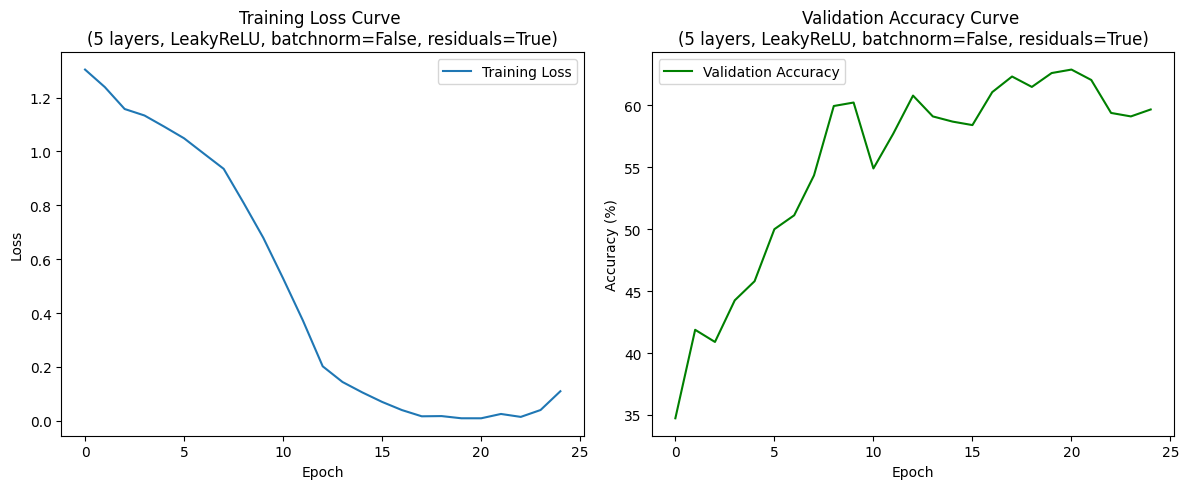

Text appended to AllAccuracies.txt successfully.
Batch normalisation: False; residuals: True; num_layers:5; activation: LeakyReLU
       Test Accuracy of the model on the 10000 test images: 59.36 %
in_channels:3, out_channels:256
4
Batch normalisation: False; residuals: True; num_layers:5; activation: GELU
Epoch [1/25], Step [50/58], Loss: 1.3119
Epoch [2/25], Step [50/58], Loss: 1.2840
Epoch [3/25], Step [50/58], Loss: 1.2101
Epoch [4/25], Step [50/58], Loss: 1.1063
Epoch [5/25], Step [50/58], Loss: 1.2402
Epoch [6/25], Step [50/58], Loss: 1.0406
Epoch [7/25], Step [50/58], Loss: 0.9399
Epoch [8/25], Step [50/58], Loss: 0.7673
Epoch [9/25], Step [50/58], Loss: 0.5099
Epoch [10/25], Step [50/58], Loss: 0.5333
Epoch [11/25], Step [50/58], Loss: 0.1264
Epoch [12/25], Step [50/58], Loss: 0.1058
Epoch [13/25], Step [50/58], Loss: 0.0578
Epoch [14/25], Step [50/58], Loss: 0.0311
Epoch [15/25], Step [50/58], Loss: 0.0021
Epoch [16/25], Step [50/58], Loss: 0.0008
Epoch [17/25], Step [50/58], 

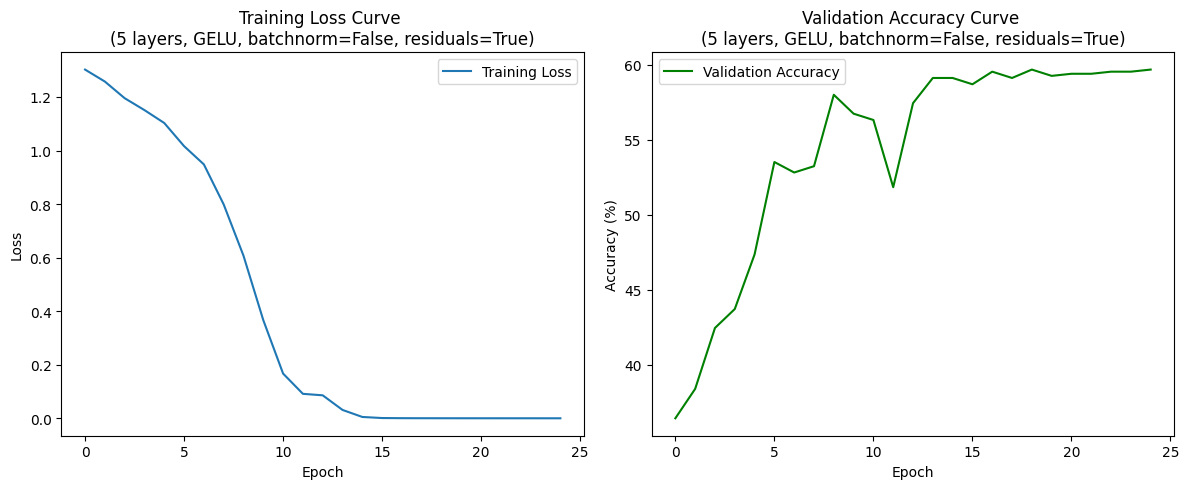

Text appended to AllAccuracies.txt successfully.
Batch normalisation: False; residuals: True; num_layers:5; activation: GELU
       Test Accuracy of the model on the 10000 test images: 59.22 %
in_channels:3, out_channels:512
2
Batch normalisation: False; residuals: True; num_layers:6; activation: ReLU
Epoch [1/25], Step [50/58], Loss: 1.2540
Epoch [2/25], Step [50/58], Loss: 1.1617
Epoch [3/25], Step [50/58], Loss: 1.2464
Epoch [4/25], Step [50/58], Loss: 1.2127
Epoch [5/25], Step [50/58], Loss: 1.2035
Epoch [6/25], Step [50/58], Loss: 1.0814
Epoch [7/25], Step [50/58], Loss: 1.1663
Epoch [8/25], Step [50/58], Loss: 1.0454
Epoch [9/25], Step [50/58], Loss: 1.0795
Epoch [10/25], Step [50/58], Loss: 1.1023
Epoch [11/25], Step [50/58], Loss: 1.0135
Epoch [12/25], Step [50/58], Loss: 0.9655
Epoch [13/25], Step [50/58], Loss: 0.8063
Epoch [14/25], Step [50/58], Loss: 0.7575
Epoch [15/25], Step [50/58], Loss: 0.7287
Epoch [16/25], Step [50/58], Loss: 0.5545
Epoch [17/25], Step [50/58], Loss:

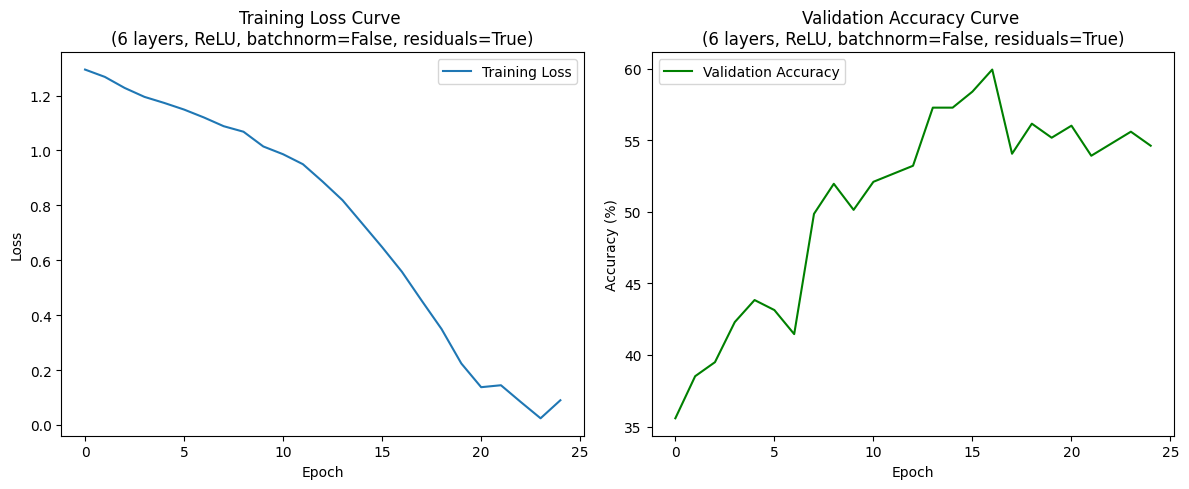

Text appended to AllAccuracies.txt successfully.
Batch normalisation: False; residuals: True; num_layers:6; activation: ReLU
       Test Accuracy of the model on the 10000 test images: 51.82 %
in_channels:3, out_channels:512
2
Batch normalisation: False; residuals: True; num_layers:6; activation: LeakyReLU
Epoch [1/25], Step [50/58], Loss: 1.2407
Epoch [2/25], Step [50/58], Loss: 1.2518
Epoch [3/25], Step [50/58], Loss: 1.2316
Epoch [4/25], Step [50/58], Loss: 1.1856
Epoch [5/25], Step [50/58], Loss: 1.3234
Epoch [6/25], Step [50/58], Loss: 1.0708
Epoch [7/25], Step [50/58], Loss: 1.2029
Epoch [8/25], Step [50/58], Loss: 1.0471
Epoch [9/25], Step [50/58], Loss: 0.9011
Epoch [10/25], Step [50/58], Loss: 0.8639
Epoch [11/25], Step [50/58], Loss: 0.6241
Epoch [12/25], Step [50/58], Loss: 0.5138
Epoch [13/25], Step [50/58], Loss: 0.3830
Epoch [14/25], Step [50/58], Loss: 0.3378
Epoch [15/25], Step [50/58], Loss: 0.1580
Epoch [16/25], Step [50/58], Loss: 0.0641
Epoch [17/25], Step [50/58], 

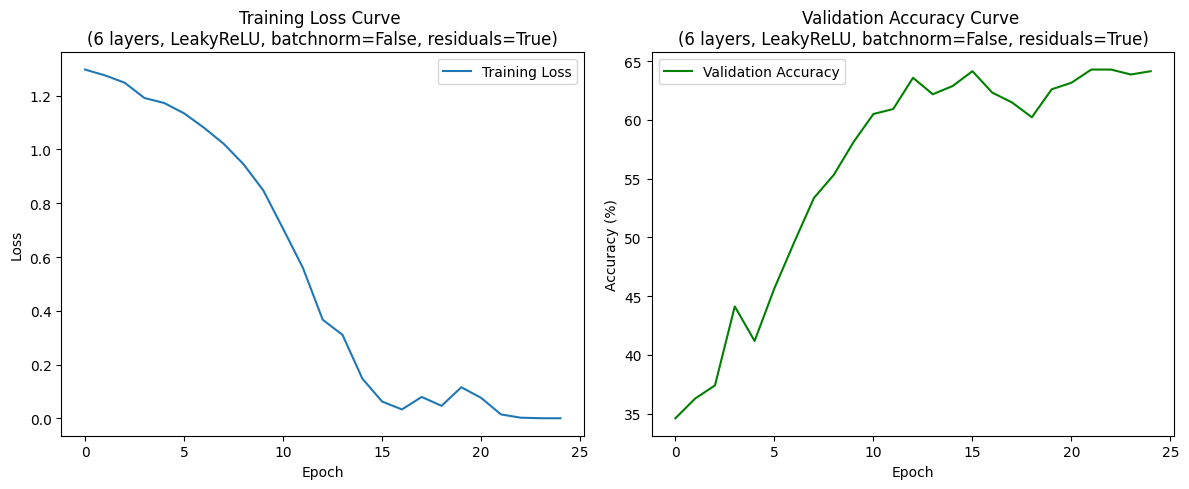

Text appended to AllAccuracies.txt successfully.
Batch normalisation: False; residuals: True; num_layers:6; activation: LeakyReLU
       Test Accuracy of the model on the 10000 test images: 62.99 %
in_channels:3, out_channels:512
2
Batch normalisation: False; residuals: True; num_layers:6; activation: GELU
Epoch [1/25], Step [50/58], Loss: 1.3024
Epoch [2/25], Step [50/58], Loss: 1.3171
Epoch [3/25], Step [50/58], Loss: 1.2711
Epoch [4/25], Step [50/58], Loss: 1.1839
Epoch [5/25], Step [50/58], Loss: 1.1415
Epoch [6/25], Step [50/58], Loss: 1.1122
Epoch [7/25], Step [50/58], Loss: 1.1427
Epoch [8/25], Step [50/58], Loss: 0.9194
Epoch [9/25], Step [50/58], Loss: 0.9431
Epoch [10/25], Step [50/58], Loss: 0.7627
Epoch [11/25], Step [50/58], Loss: 0.4904
Epoch [12/25], Step [50/58], Loss: 0.4317
Epoch [13/25], Step [50/58], Loss: 0.1900
Epoch [14/25], Step [50/58], Loss: 0.0664
Epoch [15/25], Step [50/58], Loss: 0.1199
Epoch [16/25], Step [50/58], Loss: 0.0478
Epoch [17/25], Step [50/58], 

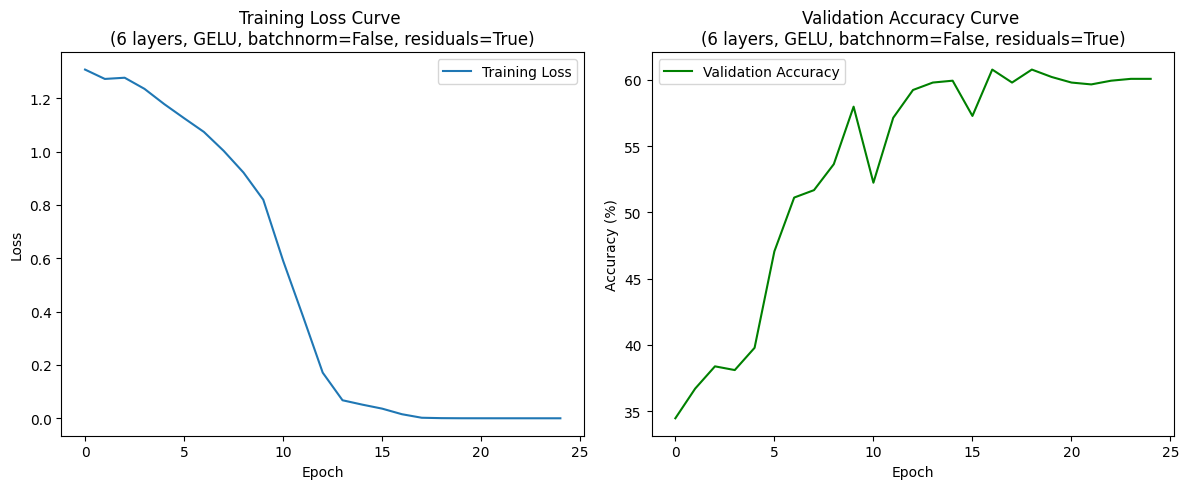

Text appended to AllAccuracies.txt successfully.
Batch normalisation: False; residuals: True; num_layers:6; activation: GELU
       Test Accuracy of the model on the 10000 test images: 61.03 %
16
Batch normalisation: False; residuals: False; num_layers:3; activation: ReLU
Epoch [1/25], Step [50/58], Loss: 1.2059
Epoch [2/25], Step [50/58], Loss: 1.1979
Epoch [3/25], Step [50/58], Loss: 1.0573
Epoch [4/25], Step [50/58], Loss: 1.0442
Epoch [5/25], Step [50/58], Loss: 0.9636
Epoch [6/25], Step [50/58], Loss: 0.8203
Epoch [7/25], Step [50/58], Loss: 0.9637
Epoch [8/25], Step [50/58], Loss: 0.7162
Epoch [9/25], Step [50/58], Loss: 0.6301
Epoch [10/25], Step [50/58], Loss: 0.4167
Epoch [11/25], Step [50/58], Loss: 0.4817
Epoch [12/25], Step [50/58], Loss: 0.1918
Epoch [13/25], Step [50/58], Loss: 0.1919
Epoch [14/25], Step [50/58], Loss: 0.1274
Epoch [15/25], Step [50/58], Loss: 0.0528
Epoch [16/25], Step [50/58], Loss: 0.0158
Epoch [17/25], Step [50/58], Loss: 0.0124
Epoch [18/25], Step [5

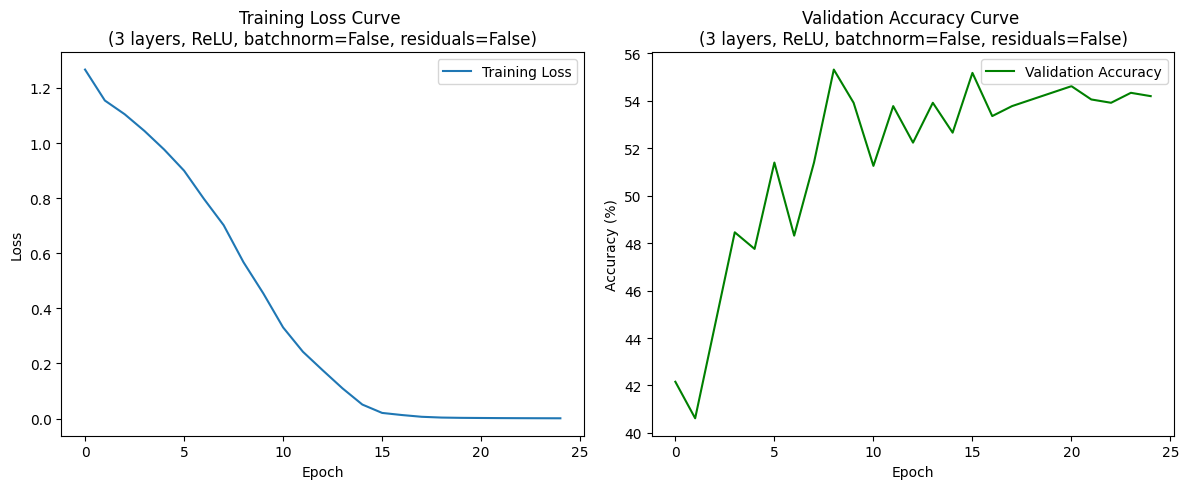

Text appended to AllAccuracies.txt successfully.
Batch normalisation: False; residuals: False; num_layers:3; activation: ReLU
       Test Accuracy of the model on the 10000 test images: 54.19 %
16
Batch normalisation: False; residuals: False; num_layers:3; activation: LeakyReLU
Epoch [1/25], Step [50/58], Loss: 1.1454
Epoch [2/25], Step [50/58], Loss: 1.1380
Epoch [3/25], Step [50/58], Loss: 1.0276
Epoch [4/25], Step [50/58], Loss: 1.0603
Epoch [5/25], Step [50/58], Loss: 0.9223
Epoch [6/25], Step [50/58], Loss: 0.9102
Epoch [7/25], Step [50/58], Loss: 0.7714
Epoch [8/25], Step [50/58], Loss: 0.7848
Epoch [9/25], Step [50/58], Loss: 0.5572
Epoch [10/25], Step [50/58], Loss: 0.5605
Epoch [11/25], Step [50/58], Loss: 0.3606
Epoch [12/25], Step [50/58], Loss: 0.2840
Epoch [13/25], Step [50/58], Loss: 0.1860
Epoch [14/25], Step [50/58], Loss: 0.1190
Epoch [15/25], Step [50/58], Loss: 0.0845
Epoch [16/25], Step [50/58], Loss: 0.0502
Epoch [17/25], Step [50/58], Loss: 0.0117
Epoch [18/25], S

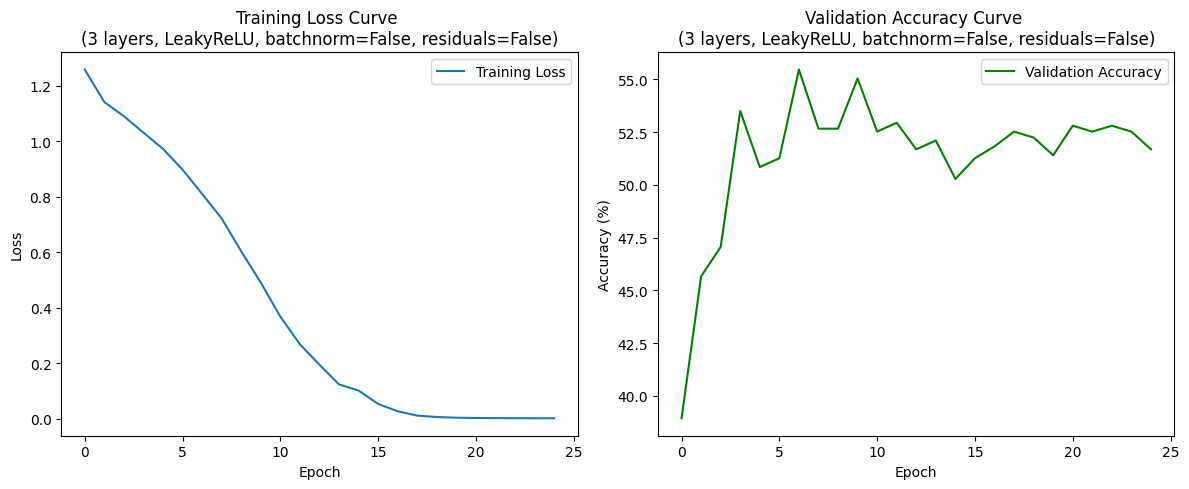

Text appended to AllAccuracies.txt successfully.
Batch normalisation: False; residuals: False; num_layers:3; activation: LeakyReLU
       Test Accuracy of the model on the 10000 test images: 57.96 %
16
Batch normalisation: False; residuals: False; num_layers:3; activation: GELU
Epoch [1/25], Step [50/58], Loss: 1.2666
Epoch [2/25], Step [50/58], Loss: 1.2133
Epoch [3/25], Step [50/58], Loss: 1.1752
Epoch [4/25], Step [50/58], Loss: 1.1181
Epoch [5/25], Step [50/58], Loss: 1.0895
Epoch [6/25], Step [50/58], Loss: 0.9093
Epoch [7/25], Step [50/58], Loss: 0.9282
Epoch [8/25], Step [50/58], Loss: 0.9249
Epoch [9/25], Step [50/58], Loss: 0.7535
Epoch [10/25], Step [50/58], Loss: 0.7133
Epoch [11/25], Step [50/58], Loss: 0.6662
Epoch [12/25], Step [50/58], Loss: 0.6432
Epoch [13/25], Step [50/58], Loss: 0.4179
Epoch [14/25], Step [50/58], Loss: 0.3314
Epoch [15/25], Step [50/58], Loss: 0.1644
Epoch [16/25], Step [50/58], Loss: 0.0738
Epoch [17/25], Step [50/58], Loss: 0.0693
Epoch [18/25], S

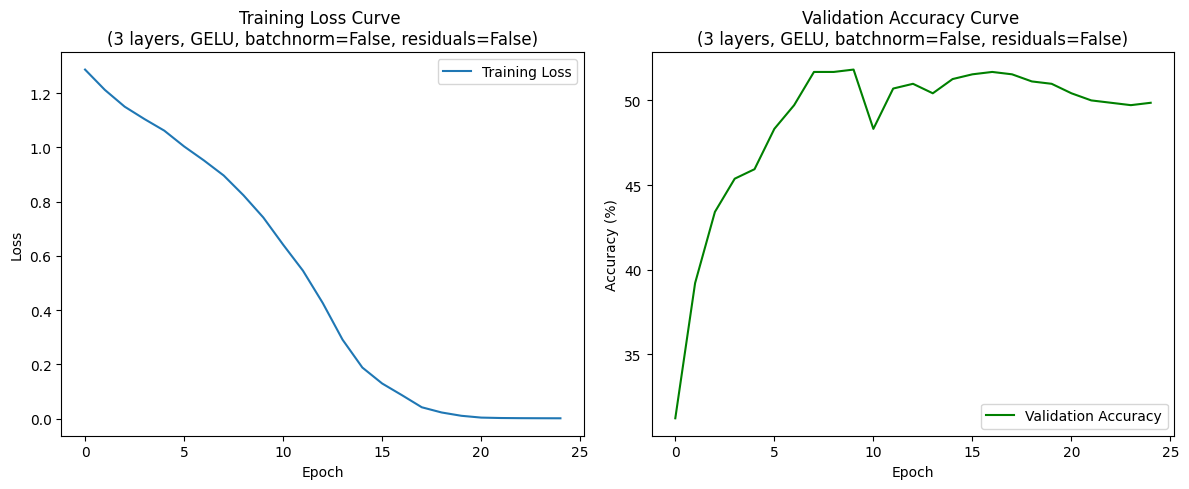

Text appended to AllAccuracies.txt successfully.
Batch normalisation: False; residuals: False; num_layers:3; activation: GELU
       Test Accuracy of the model on the 10000 test images: 50.84 %
8
Batch normalisation: False; residuals: False; num_layers:4; activation: ReLU
Epoch [1/25], Step [50/58], Loss: 1.3510
Epoch [2/25], Step [50/58], Loss: 1.1665
Epoch [3/25], Step [50/58], Loss: 1.1742
Epoch [4/25], Step [50/58], Loss: 1.0884
Epoch [5/25], Step [50/58], Loss: 1.0088
Epoch [6/25], Step [50/58], Loss: 1.1220
Epoch [7/25], Step [50/58], Loss: 0.8910
Epoch [8/25], Step [50/58], Loss: 0.7616
Epoch [9/25], Step [50/58], Loss: 0.7727
Epoch [10/25], Step [50/58], Loss: 0.8061
Epoch [11/25], Step [50/58], Loss: 0.6901
Epoch [12/25], Step [50/58], Loss: 0.4377
Epoch [13/25], Step [50/58], Loss: 0.3477
Epoch [14/25], Step [50/58], Loss: 0.3689
Epoch [15/25], Step [50/58], Loss: 0.2376
Epoch [16/25], Step [50/58], Loss: 0.0939
Epoch [17/25], Step [50/58], Loss: 0.0873
Epoch [18/25], Step [5

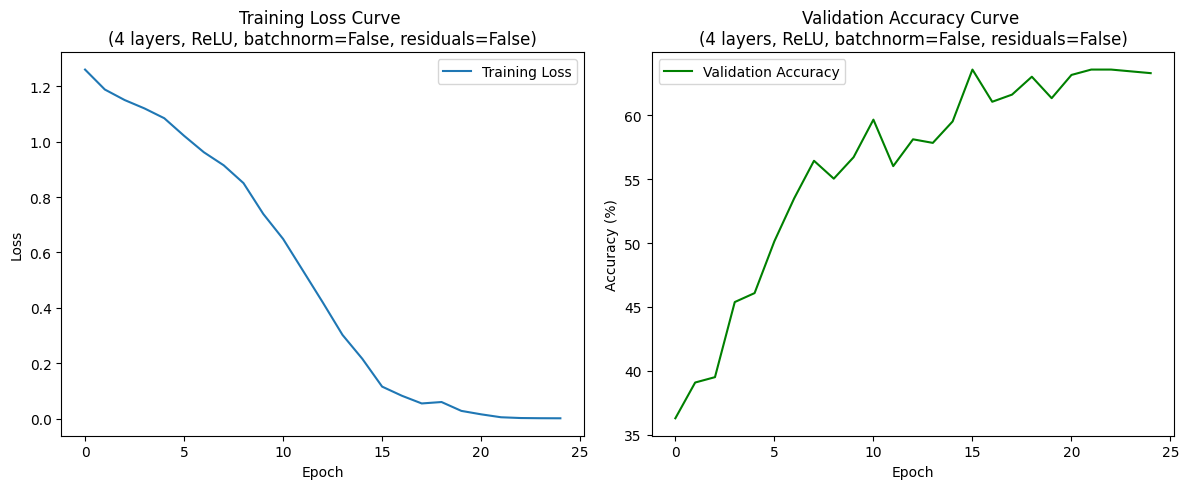

Text appended to AllAccuracies.txt successfully.
Batch normalisation: False; residuals: False; num_layers:4; activation: ReLU
       Test Accuracy of the model on the 10000 test images: 63.13 %
8
Batch normalisation: False; residuals: False; num_layers:4; activation: LeakyReLU
Epoch [1/25], Step [50/58], Loss: 1.2167
Epoch [2/25], Step [50/58], Loss: 1.2149
Epoch [3/25], Step [50/58], Loss: 1.2074
Epoch [4/25], Step [50/58], Loss: 0.9954
Epoch [5/25], Step [50/58], Loss: 1.0349
Epoch [6/25], Step [50/58], Loss: 1.0686
Epoch [7/25], Step [50/58], Loss: 0.7607
Epoch [8/25], Step [50/58], Loss: 0.7618
Epoch [9/25], Step [50/58], Loss: 0.7303
Epoch [10/25], Step [50/58], Loss: 0.4458
Epoch [11/25], Step [50/58], Loss: 0.1986
Epoch [12/25], Step [50/58], Loss: 0.2078
Epoch [13/25], Step [50/58], Loss: 0.1080
Epoch [14/25], Step [50/58], Loss: 0.1807
Epoch [15/25], Step [50/58], Loss: 0.0859
Epoch [16/25], Step [50/58], Loss: 0.0245
Epoch [17/25], Step [50/58], Loss: 0.0109
Epoch [18/25], St

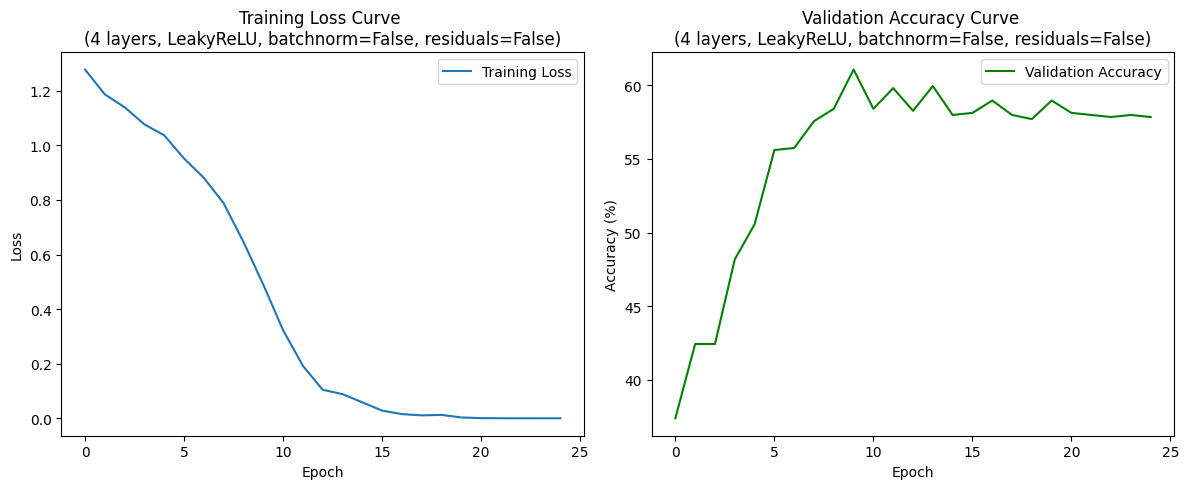

Text appended to AllAccuracies.txt successfully.
Batch normalisation: False; residuals: False; num_layers:4; activation: LeakyReLU
       Test Accuracy of the model on the 10000 test images: 60.47 %
8
Batch normalisation: False; residuals: False; num_layers:4; activation: GELU
Epoch [1/25], Step [50/58], Loss: 1.2382
Epoch [2/25], Step [50/58], Loss: 1.1860
Epoch [3/25], Step [50/58], Loss: 1.2649
Epoch [4/25], Step [50/58], Loss: 1.1722
Epoch [5/25], Step [50/58], Loss: 1.1016
Epoch [6/25], Step [50/58], Loss: 1.0515
Epoch [7/25], Step [50/58], Loss: 0.9843
Epoch [8/25], Step [50/58], Loss: 0.8811
Epoch [9/25], Step [50/58], Loss: 0.9085
Epoch [10/25], Step [50/58], Loss: 0.7237
Epoch [11/25], Step [50/58], Loss: 0.6186
Epoch [12/25], Step [50/58], Loss: 0.3677
Epoch [13/25], Step [50/58], Loss: 0.2552
Epoch [14/25], Step [50/58], Loss: 0.1027
Epoch [15/25], Step [50/58], Loss: 0.0212
Epoch [16/25], Step [50/58], Loss: 0.0094
Epoch [17/25], Step [50/58], Loss: 0.0379
Epoch [18/25], St

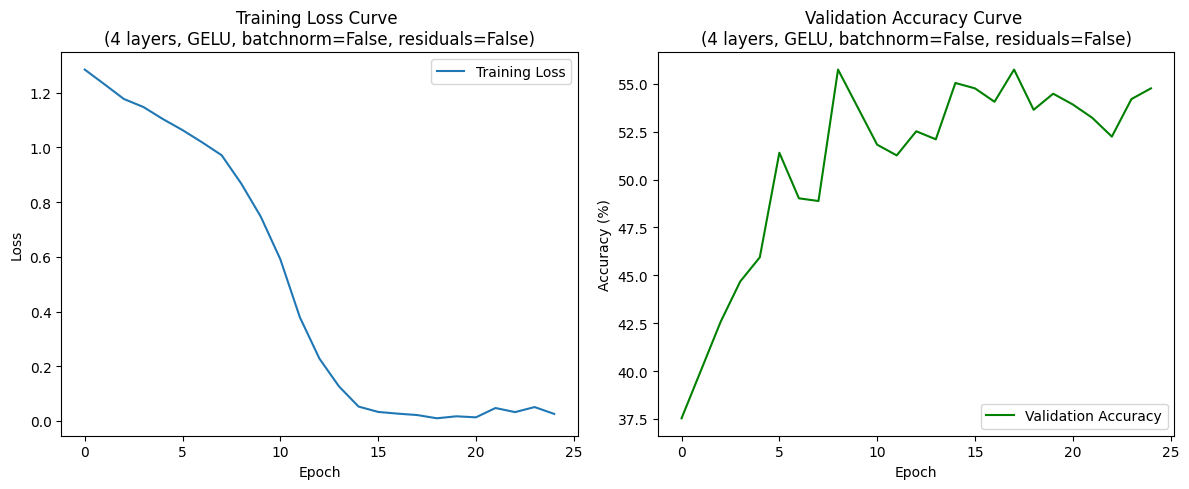

Text appended to AllAccuracies.txt successfully.
Batch normalisation: False; residuals: False; num_layers:4; activation: GELU
       Test Accuracy of the model on the 10000 test images: 56.98 %
4
Batch normalisation: False; residuals: False; num_layers:5; activation: ReLU
Epoch [1/25], Step [50/58], Loss: 1.3104
Epoch [2/25], Step [50/58], Loss: 1.2956
Epoch [3/25], Step [50/58], Loss: 1.3067
Epoch [4/25], Step [50/58], Loss: 1.2187
Epoch [5/25], Step [50/58], Loss: 1.1979
Epoch [6/25], Step [50/58], Loss: 1.1182
Epoch [7/25], Step [50/58], Loss: 1.1403
Epoch [8/25], Step [50/58], Loss: 1.1434
Epoch [9/25], Step [50/58], Loss: 1.0923
Epoch [10/25], Step [50/58], Loss: 0.7960
Epoch [11/25], Step [50/58], Loss: 0.9410
Epoch [12/25], Step [50/58], Loss: 0.7803
Epoch [13/25], Step [50/58], Loss: 0.7474
Epoch [14/25], Step [50/58], Loss: 0.4833
Epoch [15/25], Step [50/58], Loss: 0.5030
Epoch [16/25], Step [50/58], Loss: 0.3391
Epoch [17/25], Step [50/58], Loss: 0.1760
Epoch [18/25], Step [5

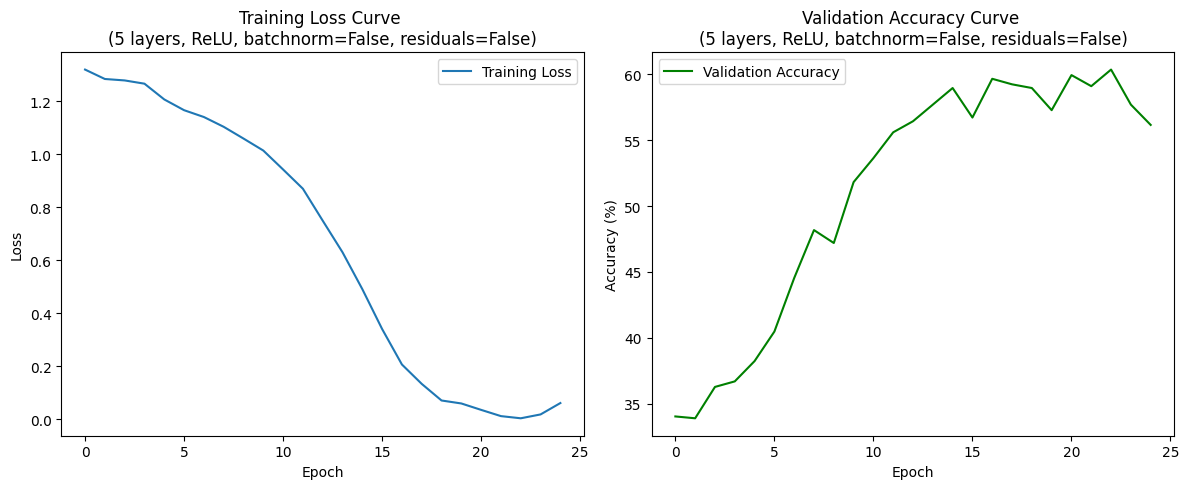

Text appended to AllAccuracies.txt successfully.
Batch normalisation: False; residuals: False; num_layers:5; activation: ReLU
       Test Accuracy of the model on the 10000 test images: 58.38 %
4
Batch normalisation: False; residuals: False; num_layers:5; activation: LeakyReLU
Epoch [1/25], Step [50/58], Loss: 1.3009
Epoch [2/25], Step [50/58], Loss: 1.1764
Epoch [3/25], Step [50/58], Loss: 1.1199
Epoch [4/25], Step [50/58], Loss: 1.0279
Epoch [5/25], Step [50/58], Loss: 1.1450
Epoch [6/25], Step [50/58], Loss: 1.0197
Epoch [7/25], Step [50/58], Loss: 0.9289
Epoch [8/25], Step [50/58], Loss: 0.8537
Epoch [9/25], Step [50/58], Loss: 0.6355
Epoch [10/25], Step [50/58], Loss: 0.5157
Epoch [11/25], Step [50/58], Loss: 0.2259
Epoch [12/25], Step [50/58], Loss: 0.1829
Epoch [13/25], Step [50/58], Loss: 0.1296
Epoch [14/25], Step [50/58], Loss: 0.0694
Epoch [15/25], Step [50/58], Loss: 0.0061
Epoch [16/25], Step [50/58], Loss: 0.0517
Epoch [17/25], Step [50/58], Loss: 0.0036
Epoch [18/25], St

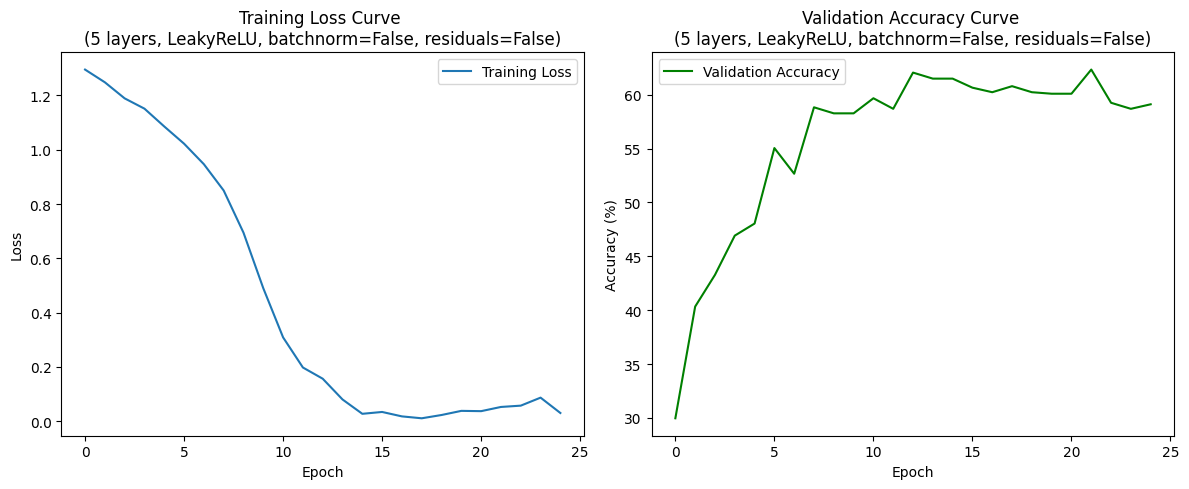

Text appended to AllAccuracies.txt successfully.
Batch normalisation: False; residuals: False; num_layers:5; activation: LeakyReLU
       Test Accuracy of the model on the 10000 test images: 62.43 %
4
Batch normalisation: False; residuals: False; num_layers:5; activation: GELU
Epoch [1/25], Step [50/58], Loss: 1.2913
Epoch [2/25], Step [50/58], Loss: 1.2161
Epoch [3/25], Step [50/58], Loss: 1.2063
Epoch [4/25], Step [50/58], Loss: 1.2470
Epoch [5/25], Step [50/58], Loss: 1.1842
Epoch [6/25], Step [50/58], Loss: 0.9225
Epoch [7/25], Step [50/58], Loss: 1.0436
Epoch [8/25], Step [50/58], Loss: 0.9068
Epoch [9/25], Step [50/58], Loss: 0.6667
Epoch [10/25], Step [50/58], Loss: 0.4759
Epoch [11/25], Step [50/58], Loss: 0.2579
Epoch [12/25], Step [50/58], Loss: 0.2301
Epoch [13/25], Step [50/58], Loss: 0.0766
Epoch [14/25], Step [50/58], Loss: 0.0197
Epoch [15/25], Step [50/58], Loss: 0.0238
Epoch [16/25], Step [50/58], Loss: 0.0125
Epoch [17/25], Step [50/58], Loss: 0.0214
Epoch [18/25], St

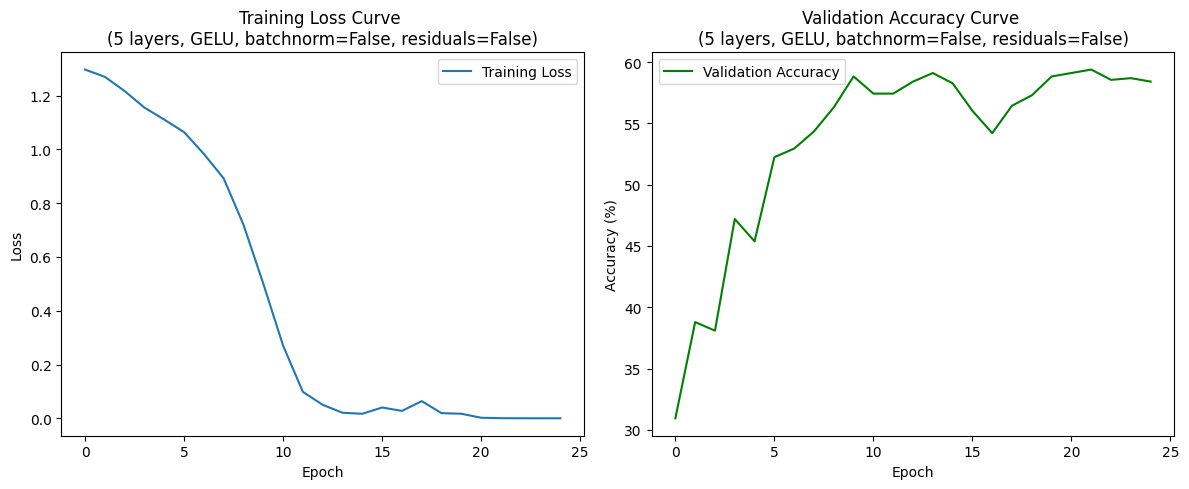

Text appended to AllAccuracies.txt successfully.
Batch normalisation: False; residuals: False; num_layers:5; activation: GELU
       Test Accuracy of the model on the 10000 test images: 59.36 %
2
Batch normalisation: False; residuals: False; num_layers:6; activation: ReLU
Epoch [1/25], Step [50/58], Loss: 1.2558
Epoch [2/25], Step [50/58], Loss: 1.3404
Epoch [3/25], Step [50/58], Loss: 1.2746
Epoch [4/25], Step [50/58], Loss: 1.2833
Epoch [5/25], Step [50/58], Loss: 1.2622
Epoch [6/25], Step [50/58], Loss: 1.3471
Epoch [7/25], Step [50/58], Loss: 1.2580
Epoch [8/25], Step [50/58], Loss: 1.3256
Epoch [9/25], Step [50/58], Loss: 1.1978
Epoch [10/25], Step [50/58], Loss: 1.1141
Epoch [11/25], Step [50/58], Loss: 1.1576
Epoch [12/25], Step [50/58], Loss: 1.1892
Epoch [13/25], Step [50/58], Loss: 1.0175
Epoch [14/25], Step [50/58], Loss: 1.0312
Epoch [15/25], Step [50/58], Loss: 0.9337
Epoch [16/25], Step [50/58], Loss: 0.6903
Epoch [17/25], Step [50/58], Loss: 0.8182
Epoch [18/25], Step [5

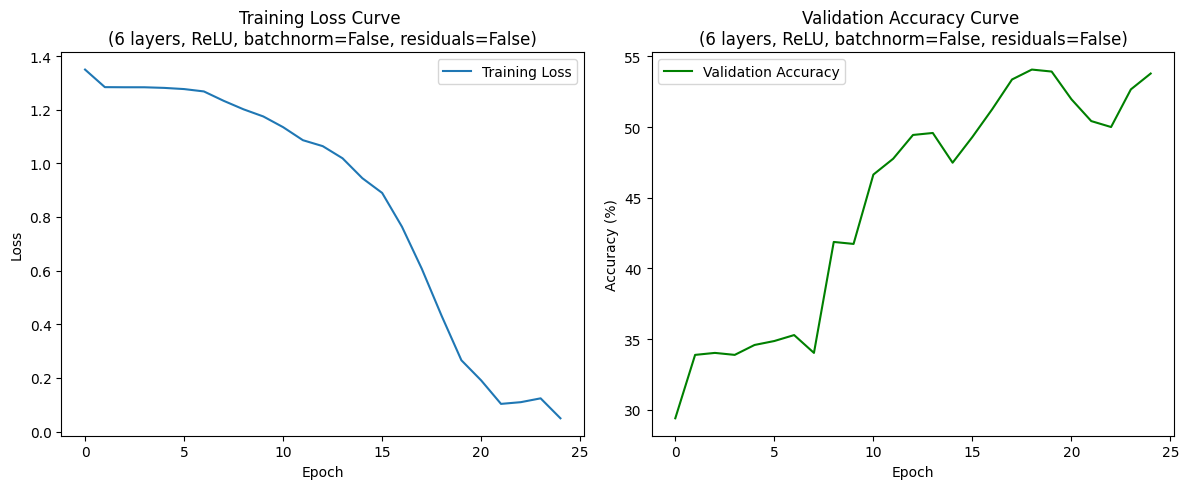

Text appended to AllAccuracies.txt successfully.
Batch normalisation: False; residuals: False; num_layers:6; activation: ReLU
       Test Accuracy of the model on the 10000 test images: 49.58 %
2
Batch normalisation: False; residuals: False; num_layers:6; activation: LeakyReLU
Epoch [1/25], Step [50/58], Loss: 1.2717
Epoch [2/25], Step [50/58], Loss: 1.3020
Epoch [3/25], Step [50/58], Loss: 1.2106
Epoch [4/25], Step [50/58], Loss: 1.2030
Epoch [5/25], Step [50/58], Loss: 1.1465
Epoch [6/25], Step [50/58], Loss: 1.2074
Epoch [7/25], Step [50/58], Loss: 1.0132
Epoch [8/25], Step [50/58], Loss: 1.0484
Epoch [9/25], Step [50/58], Loss: 0.9370
Epoch [10/25], Step [50/58], Loss: 1.0831
Epoch [11/25], Step [50/58], Loss: 0.7017
Epoch [12/25], Step [50/58], Loss: 0.7203
Epoch [13/25], Step [50/58], Loss: 0.5176
Epoch [14/25], Step [50/58], Loss: 0.2323
Epoch [15/25], Step [50/58], Loss: 0.1272
Epoch [16/25], Step [50/58], Loss: 0.1648
Epoch [17/25], Step [50/58], Loss: 0.1643
Epoch [18/25], St

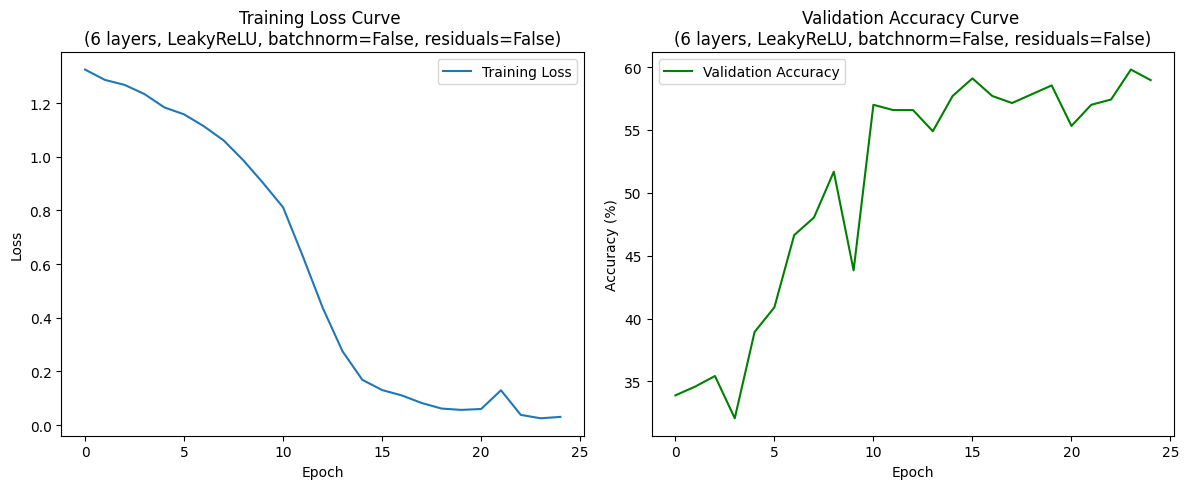

Text appended to AllAccuracies.txt successfully.
Batch normalisation: False; residuals: False; num_layers:6; activation: LeakyReLU
       Test Accuracy of the model on the 10000 test images: 62.15 %
2
Batch normalisation: False; residuals: False; num_layers:6; activation: GELU
Epoch [1/25], Step [50/58], Loss: 1.2717
Epoch [2/25], Step [50/58], Loss: 1.2895
Epoch [3/25], Step [50/58], Loss: 1.1644
Epoch [4/25], Step [50/58], Loss: 1.1644
Epoch [5/25], Step [50/58], Loss: 1.0592
Epoch [6/25], Step [50/58], Loss: 1.0000
Epoch [7/25], Step [50/58], Loss: 1.1719
Epoch [8/25], Step [50/58], Loss: 1.1650
Epoch [9/25], Step [50/58], Loss: 0.9719
Epoch [10/25], Step [50/58], Loss: 0.7156
Epoch [11/25], Step [50/58], Loss: 0.6326
Epoch [12/25], Step [50/58], Loss: 0.1978
Epoch [13/25], Step [50/58], Loss: 0.1146
Epoch [14/25], Step [50/58], Loss: 0.0869
Epoch [15/25], Step [50/58], Loss: 0.0781
Epoch [16/25], Step [50/58], Loss: 0.0488
Epoch [17/25], Step [50/58], Loss: 0.0313
Epoch [18/25], St

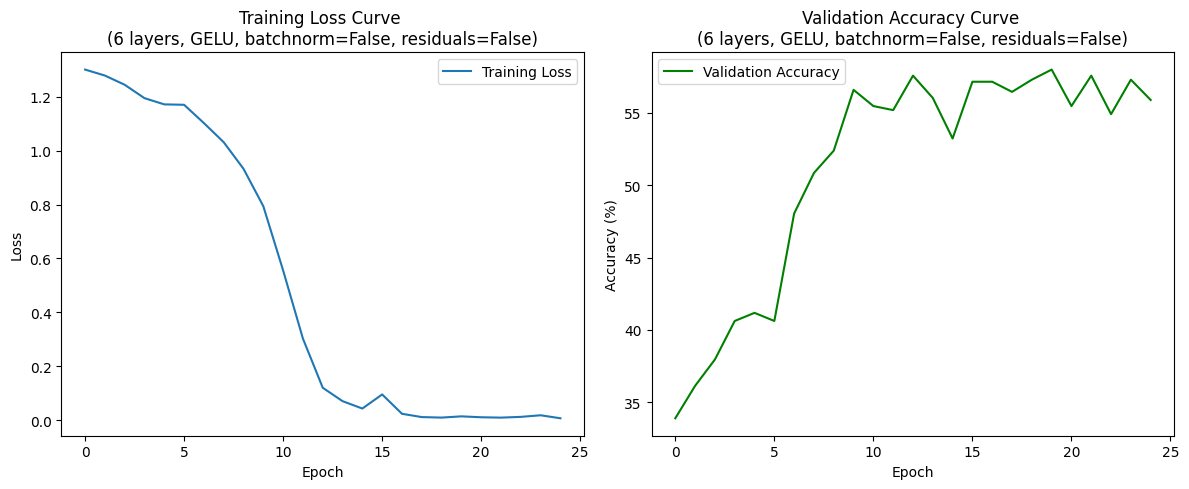

Text appended to AllAccuracies.txt successfully.
Batch normalisation: False; residuals: False; num_layers:6; activation: GELU
       Test Accuracy of the model on the 10000 test images: 58.52 %


In [19]:
def run_model():
    #hyperparameters
    num_epochs = 25
    num_classes = 4
    batch_size = 100
    learning_rate = 0.001

    #this is stupid as hell but my computer died trying to do 7 layers last night and i want to do every permutation
    #which means. this must be automated
    #so now we're going to check what we tested last time we rendered
    models_ive_trained = extract_models_from_file("AllAccuracies.txt")

    bools = [ True, False ]
    num_layers = [3, 4, 5, 6 ] #removed 7 as returns were diminishing on 6 and 7 gets an out of memory error
    activation_funcs = ["ReLU", "LeakyReLU", "GELU"]

    #our dataloader for training dataset
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    #validation loader
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
    #selecting device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #printing because my main kernel wants to be stuck on CPU-only pytorch fsr
    print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")
    for z in range(len(bools)):
        batch_bool = bools[z]
        for m in range(len(bools)):
            residual = bools[m]
            for j in range(len(num_layers)):
                num_layer = num_layers[j]
                for k in range(len(activation_funcs)):
                    activation_func = activation_funcs[k]
                    this_model = f"{batch_bool}{residual}{num_layer}{activation_func}"
                    if this_model in models_ive_trained:
                        print("We've already trained this model, it's getting skipped.")
                    else:
                        model = configConvNet(batch_normal=batch_bool, num_layers=num_layer, activation=activation_func, residuals=residual).to(device)
        
                        # Loss and optimizer
                        criterion = nn.CrossEntropyLoss()
                        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
                        train_losses = []
                        val_accuracies = []
                        
                        # Train the model
                        total_step = len(train_loader)
                        descript = f"Batch normalisation: {bools[z]}; residuals: {bools[m]}; num_layers:{num_layers[j]}; activation: {activation_funcs[k]}";
                        print(descript)
                        
                        for epoch in range(num_epochs):
                            model.train()
                            epoch_loss = 0
                            for i, (images, labels) in enumerate(train_loader):
                                images = images.to(device)
                                labels = labels.to(device)
                                # Forward pass
                                outputs = model(images)
                                loss = criterion(outputs, labels)
        
                                # Backward and optimize
                                optimizer.zero_grad()
                                loss.backward()
                                optimizer.step()
                                epoch_loss += loss.item()                            
                                if (i+1) % 50 == 0:
                                    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
                            
                            avg_loss = epoch_loss / total_step
                            train_losses.append(avg_loss)
                                
                            #now we do validation. exit training mode
                            model.eval()
                            correct = 0                       
                            total = 0
                            with torch.no_grad():
                                for images, labels in val_loader:
                                    images = images.to(device)
                                    labels = labels.to(device)
                                    outputs = model(images)
                                    _, predicted = torch.max(outputs.data, 1)
                                    total += labels.size(0)
                                    correct += (predicted == labels).sum().item()
                            accuracy = 100 * correct / total
                            val_accuracies.append(accuracy)
                            #print(f'Validation Accuracy after epoch {epoch+1}: {accuracy:.2f}%')
                        generate_charts(num_layers=num_layer, activation=activation_func,batch_norm=batch_bool, residuals=residual, train_losses=train_losses, val_accuracies=val_accuracies)                    
                        test_model(model, descript, batch_size, device)
run_model()